Building recommendation systems using SVD++ and ItemKNN
---

In [267]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [230]:
file_path = r"C:\Users\vahav\OneDrive - HvA\Courses\System Development for Marketing\E-commerce\ecommerce_data.csv"
e_commerce = pd.read_csv(file_path)

# Set the display option to show all columns
pd.set_option('display.max_columns', None)

(e_commerce.head())

,Customer_ID,Age,Gender,Income_Level,Marital_Status,Education_Level,Occupation,Location,Purchase_Category,Purchase_Amount,Frequency_of_Purchase,Purchase_Channel,Brand_Loyalty,Product_Rating,Time_Spent_on_Product_Research(hours),Social_Media_Influence,Discount_Sensitivity,Return_Rate,Customer_Satisfaction,Engagement_with_Ads,Device_Used_for_Shopping,Payment_Method,Time_of_Purchase,Discount_Used,Customer_Loyalty_Program_Member,Purchase_Intent,Shipping_Preference,Time_to_Decision,Age_Group,Purchase_Amount_Group
0,37-611-6911,22,Female,Middle,Married,Bachelor's,Middle,Évry,Gardening & Outdoors,333.80,4,Mixed,5,5,2.0,NaN,Somewhat Sensitive,1,7,NaN,Tablet,Credit Card,3/1/2024,True,False,Need-based,No Preference,2,18–25,$251–350
1,29-392-9296,49,Male,High,Married,High School,High,Huocheng,Food & Beverages,222.22,11,In-Store,3,1,2.0,Medium,Not Sensitive,1,5,High,Tablet,PayPal,4/16/2024,True,False,Wants-based,Standard,6,46–50,$151–250
2,84-649-5117,24,Female,Middle,Single,Master's,High,Huzhen,Office Supplies,426.22,2,Mixed,5,5,0.3,Low,Not Sensitive,1,7,Low,Smartphone,Debit Card,3/15/2024,True,True,Impulsive,No Preference,3,18–25,$351–450
3,48-980-6078,29,Female,Middle,Single,Master's,Middle,Wiwilí,Home Appliances,101.31,6,Mixed,3,1,1.0,High,Somewhat Sensitive,0,1,NaN,Smartphone,Other,10/4/2024,True,True,Need-based,Express,10,26–30,$50–150
4,91-170-9072,33,Female,Middle,Widowed,High School,Middle,Nara,Furniture,211.70,6,Mixed,3,4,0.0,Medium,Not Sensitive,2,10,NaN,Smartphone,Debit Card,1/30/2024,False,False,Wants-based,No Preference,4,31–35,$151–250


---
---
Model 1: SVD++
---
SVD++ is an advanced version of the Singular Value Decomposition (SVD) algorithm, used in collaborative filtering for recommendation systems. It is particularly effective for predicting user-item interactions by learning latent factors from the data, with an enhancement that takes into account implicit feedback (user behaviors) in addition to explicit ratings (the actual item ratings). The Surprise library is a popular Python library designed for building and evaluating recommender systems, and it includes an implementation of SVD++.

SVD++ in Surprise builds upon the basic SVD algorithm by incorporating implicit feedback (such as views, clicks, or purchases) along with explicit feedback (ratings). This makes it particularly effective when you have sparse rating data, but can gather additional implicit feedback from user interactions. The model works by decomposing the user-item interaction matrix into three matrices:
- User matrix (U): A matrix that represents latent features associated with users.
- Item matrix (V): A matrix that represents latent features associated with items.
- Implicit feedback matrix: This matrix captures the implicit interactions of the users with the items (such as viewing, clicking, etc.).

For SVD++ in Surprise, the input data needs to be in the following format: A user-item interaction dataset: A dataset where each entry represents a user's rating of an item, where:
- UserID: Identifies the user
- ItemID: Identifies the item
- Rating: The rating the user gave to the item

Surprise offers the SVDpp class, which can be instantiated with parameters:
- n_factors: The number of latent factors (typically between 50 and 200).
- lr_all: The learning rate for the gradient descent optimization.
- reg_all: The regularization parameter to prevent overfitting.
- n_epochs: The number of iterations to train the model.


**NOTE:**
Because in this dataset there is record of only one purhcase for each user, we will have to think about recommending users to items rather than items to users. So for the user-item matrix, this means having in each row all the different items (purchase category) and on columns each user (customer).

The underlying logic: "“Which users are most likely to engage with (or be targeted for) a given product category?”"

- Standard setup: User = Customer_ID, Item = Purchase_Category, Rating = Product_Rating
- Flipped setup: User = Purchase_Category, Item = Customer_ID, Rating = Product_Rating

---
The objective of this model is to build a personalized recommender system using SVD++ from Surprise, and evaluate performance on an e-commerce dataset by leveraging both standard product ratings and a custom rating formula. The model outputs are then later evaluated using both individual user and group fairness metrics. The process is as follows:

1. Flipped User-Item Structure: Instead of the typical user → item setup, you flipped the structure:
    - User = Product Category
    - Item = Customer
    - This allowes to create recommendations of customers to product categories, which can tehn be switched to get the top 10 predictions for each user. This was done, because the dataset only has 1 user-item interaction for each customer (= 1 rating per customer).

2. Standard Model Training
    - A baseline SVD++ model is trained using just the raw product ratings (Product_Rating) as the prediction target.
    - Surprise's Trainset and testset structures were used for model fitting and evaluation.
    - The model evaluated happens using:
        - RMSE (Root Mean Squared Error)
        - MAE (Mean Absolute Error)

3. Hyperparameter Tuning (Grid Search)
    - Performing GridSearchCV over multiple parameter combinations (n_factors, n_epochs, lr_all, reg_all).
    - Selecting the best model based on lowest RMSE.

4. Custom Rating Design
    - Introducing a custom rating that combines:
        - Product rating (50%)
        - Customer satisfaction (30%)
        - Brand loyalty (20%)
    - This better reflects overall customer sentiment and product quality.

5. New SVD++ Model on Custom Ratings
    - Repeating the train-test split and model training using the custom rating.
    - Adjusting the rating scale to match the new composite score range.
    - Re-running GridSearchCV to find optimal hyperparameters for the custom rating model.
    - Builing and evaluating a final SVD++ model using the best hyperparameters.

6. Top-N Recommendation Generation
    - Generating top-10 recommended customers per category.
    - Flipping the normal logic back and generating top-10 recommended categories per customer.

---
Printing product category stats:

In [231]:
# Compute number of reviews and average rating per product category
category_stats = e_commerce.groupby('Purchase_Category')['Product_Rating'].agg(['count', 'mean']).reset_index()
category_stats.columns = ['Purchase_Category', 'Num_Reviews', 'Avg_Rating']

# Sort by most reviewed categories
category_stats.sort_values(by='Num_Reviews', ascending=False)

,Purchase_Category,Num_Reviews,Avg_Rating
6,Electronics,54,2.888889
21,Sports & Outdoors,51,2.882353
13,Home Appliances,50,2.940000
15,Jewelry & Accessories,50,2.760000
22,Toys & Games,47,3.468085
0,Animal Feed,44,3.000000
7,Food & Beverages,44,2.704545
9,Gardening & Outdoors,44,2.568182
20,Software & Apps,43,3.162791
19,Packages),43,3.046512


It seems that each category has enough reviews so we don't have to drop any of them. However, it's notable to say that the average reviews for each are pretty low. Nothing is above 4.

Imports the necessary classes from the Surprise library to build, train, and evaluate your SVD++ recommender model:
- SVDpp: An algorithm used in collaborative filtering for recommendation systems. It works by decomposing the user-item interaction matrix into latent factors (user and item features) and then optimizing them to predict ratings. SVD++ improves upon traditional SVD by also incorporating implicit feedback (e.g., clicks or views), making it more effective in sparse datasets.  The implicit feedback is automatically handled by the model.
- Dataset: A class in Surprise that provides methods to load data from various sources (e.g., pandas DataFrame, CSV files, etc.) and prepares it in a format that is compatible with Surprise's algorithms. It structures the data as a user-item interaction matrix.
- Reader: A utility class in Surprise that defines how the data should be interpreted when loaded. For example, it allows you to specify the rating scale (e.g., 1 to 5) and the structure of your data (e.g., columns for user ID, item ID, and rating). It's necessary to set up Surprise with the correct data format.
- Trainset: A class in Surprise that holds the training data used by the recommendation system algorithm. It is created after the dataset is split (usually with train_test_split) and provides the necessary data structure for training the model (e.g., SVD++).
- accuracy: A module in Surprise that provides evaluation metrics (such as RMSE, MAE) to assess model performance. These metrics compare the predicted ratings with the actual ratings in the test set, helping you gauge the model's effectiveness.

Others:
- train_test_split: utility function from Scikit-learn used to split your dataset into training and testing subsets.
- defaultdict: a special kind of dictionary that automatically initializes default values if a key does not exist.


In [232]:
from surprise import SVDpp, Dataset, Reader, accuracy
from sklearn.model_selection import train_test_split
from collections import defaultdict

Defining the User-Item Structure -  flipping the logic to treat categories as users and customers as items, so that the model recommends customers for each product category (because each customer only rates one category):

In [233]:
# Flip logic: Treat product categories as 'users' and customers as 'items'
ratings_df = e_commerce[['Purchase_Category', 'Customer_ID', 'Product_Rating']].copy()
ratings_df.columns = ['userID', 'itemID', 'rating']

Performing a stratified 80/20 train-test split for each category so that each category is fairly represented in both sets:

In [234]:
# Manually split by product category (userID)
train_df = pd.DataFrame(columns=ratings_df.columns)
test_df = pd.DataFrame(columns=ratings_df.columns)

for category in ratings_df['userID'].unique():
    category_ratings = ratings_df[ratings_df['userID'] == category]
    train, test = train_test_split(category_ratings, test_size=0.2, random_state=42)
    train_df = pd.concat([train_df, train])
    test_df = pd.concat([test_df, test])

Results will be that each category will be represented in both sets (no cold-start issue for categories)
- train_df containing 80% of each category's ratings
- test_df containing 20% of each category's ratings

Confirming that the train-test split stayed close to 80/20 for each category:

In [235]:
# Validate that each category has an ~80/20 split
full_counts = ratings_df['userID'].value_counts().sort_index()
train_counts = train_df['userID'].value_counts().sort_index()
test_counts = test_df['userID'].value_counts().sort_index()

verification_df = pd.DataFrame({
    'Total_Ratings': full_counts,
    'Train_Ratings': train_counts,
    'Test_Ratings': test_counts
})

verification_df['Train_%'] = (verification_df['Train_Ratings'] / verification_df['Total_Ratings'] * 100).round(1)
verification_df['Test_%'] = (verification_df['Test_Ratings'] / verification_df['Total_Ratings'] * 100).round(1)

display(verification_df)

issues = verification_df[(verification_df['Train_%'] < 75) | (verification_df['Train_%'] > 85)]
if not issues.empty:
    print("Categories with unexpected train/test split:")
    display(issues)
else:
    print("All categories have a valid 80/20 train/test split.")

,Total_Ratings,Train_Ratings,Test_Ratings,Train_%,Test_%
userID,,,,,
Animal Feed,44,35,9,79.5,20.5
Arts & Crafts,34,27,7,79.4,20.6
Baby Products,41,32,9,78.0,22.0
Beauty & Personal Care,34,27,7,79.4,20.6
Books,37,29,8,78.4,21.6
Clothing,30,24,6,80.0,20.0
Electronics,54,43,11,79.6,20.4
Food & Beverages,44,35,9,79.5,20.5
Furniture,41,32,9,78.0,22.0


All categories have a valid 80/20 train/test split.


Defining rating scale and format data:

In [236]:
# Define rating scale
reader = Reader(rating_scale=(1, 5))

# Build Surprise trainset object from train_df
trainset = Dataset.load_from_df(train_df[['userID', 'itemID', 'rating']], reader).build_full_trainset()

# Format test_df as Surprise testset (list of tuples)
testset = list(test_df[['userID', 'itemID', 'rating']].itertuples(index=False, name=None))

The code above converts the ratings_df into a Surprise-compatible format using the Reader object.

Moving to prepare train and test sets for Surprise:

In [237]:
# Convert training and testing DataFrames into Surprise formats
"""
The training set is converted using Surprise's 'build_full_trainset()', which transforms the DataFrame into a special Trainset object used for model fitting.
The test set is converted into a list of (userID, itemID, rating) tuples, which is the required input format for the model.test() method during evaluation."
"""

trainset = Dataset.load_from_df(train_df[['userID', 'itemID', 'rating']], reader).build_full_trainset()
testset = list(test_df[['userID', 'itemID', 'rating']].itertuples(index=False, name=None))

- trainset: Surprise’s internal object used to train models.
- testset: List of tuples in (userID, itemID, rating) format, needed to evaluate the model manually using .test().

Train and Predict with SVD++:

In [238]:
# Initialize the SVD++ model
svd_model = SVDpp()

# Train the model on the training set
svd_model.fit(trainset)

# Predict on the test set
svd_predictions = svd_model.test(testset)

Evaluating model performance:

In [239]:
# Calculate and print RMSE
svd_rmse = accuracy.rmse(svd_predictions)

# Calculate and print MAE
svd_mae = accuracy.mae(svd_predictions)

RMSE: 1.3944
MAE:  1.2166


It seems that the model is not performing so good. An RMSE of 1.39 and MAE of 1.21 are relatively high when the ratings are on a 1–5 scale, meaning the model predictions are off by more than a full rating point on average.

Performing a grid search to find the best hyperparameters for the SVD++ model using the product ratings and cross-validation:

In [240]:
from surprise.model_selection import GridSearchCV
"""GridSearchCV a utility in the Surprise library that performs hyperparameter tuning for collaborative filtering models (like SVD++, KNN, etc.) using cross-validation. 
It helps find the best combination of hyperparameters for the model by evaluating multiple combinations of parameters and selecting the one that gives the best performance."""

# Defineing parameter grid
param_grid = {
    'n_factors': [20, 50, 100],
    'n_epochs': [20, 40, 60],
    'lr_all': [0.003, 0.005, 0.01],
    'reg_all': [0.02, 0.05, 0.1]
}

# Running the grid search with 3-fold cross-validation
gs = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=3, joblib_verbose=1)
gs.fit(Dataset.load_from_df(ratings_df, reader))

# Displaing the best RMSE and corresponding hyperparameters
print("Best RMSE:", gs.best_score['rmse'])
print("Best Parameters:", gs.best_params['rmse'])

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   24.5s


Best RMSE: 1.4422312000711501
Best Parameters: {'n_factors': 100, 'n_epochs': 60, 'lr_all': 0.01, 'reg_all': 0.1}


The RMSE from the GridSearch is higher than with the baseline model. Defining custom rating that better reflects user preferences by blending product rating, customer satisfaction, and brand loyalty might help with the model performance. The weights reflect their relative importance:

In [241]:
#Creating a custom rating that incorporates product ratings, customer satisfaction, and brand loyalty, with the weights reflecting teh relative importance of each factor
e_commerce['custom_rating'] = (
    0.5 * e_commerce['Product_Rating'] +
    0.3 * e_commerce['Customer_Satisfaction'] +
    0.2 * e_commerce['Brand_Loyalty']
)

(e_commerce['custom_rating'].head())

0    5.6
1    2.6
2    5.6
3    1.4
4    5.6
Name: custom_rating, dtype: float64

Preparing Surprise Dataset for custom rating:

In [242]:
# Create flipped user-item dataset using custom ratings
new_ratings_df = e_commerce[['Purchase_Category', 'Customer_ID', 'custom_rating']].copy()
new_ratings_df.columns = ['userID', 'itemID', 'rating']  # flipped

# Define the rating scale for custom scores
new_reader = Reader(rating_scale=(1, 6.5))
new_data = Dataset.load_from_df(new_ratings_df, new_reader)

In [243]:
new_ratings_df.head()

,userID,itemID,rating
0,Gardening & Outdoors,37-611-6911,5.6
1,Food & Beverages,29-392-9296,2.6
2,Office Supplies,84-649-5117,5.6
3,Home Appliances,48-980-6078,1.4
4,Furniture,91-170-9072,5.6


Performing an 80/20 stratisfied split across all product categories with using the custom rating to ensure balanced evaluation in training and testing:

In [244]:
# Manually split by category to maintain class balance
new_train_df = pd.DataFrame(columns=new_ratings_df.columns)
new_test_df = pd.DataFrame(columns=new_ratings_df.columns)

for new_category in new_ratings_df['userID'].unique():
    new_category_ratings = new_ratings_df[new_ratings_df['userID'] == new_category]
    train, test = train_test_split(new_category_ratings, test_size=0.2, random_state=42)
    new_train_df = pd.concat([new_train_df, train])
    new_test_df = pd.concat([new_test_df, test])

C:\Users\vahav\AppData\Local\Temp\ipykernel_2128\1352253803.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_train_df = pd.concat([new_train_df, train])
C:\Users\vahav\AppData\Local\Temp\ipykernel_2128\1352253803.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_test_df = pd.concat([new_test_df, test])


Formatting train/test split for Surprise:

In [245]:
# Build Surprise-compatible trainset and testset
new_trainset = Dataset.load_from_df(new_train_df[['userID', 'itemID', 'rating']], new_reader).build_full_trainset()
new_testset = list(new_test_df[['userID', 'itemID', 'rating']].itertuples(index=False, name=None))

Training an initial SVD++ model on the custom ratings, and evaluating its performance using RMSE and MAE:

In [246]:
# Train SVD++ model
new_svd_model = SVDpp()
new_svd_model.fit(new_trainset)

# Predict and evaluate on test set
new_svd_predictions = new_svd_model.test(new_testset)
new_svd_rmse = accuracy.rmse(new_svd_predictions)
new_svd_mae = accuracy.mae(new_svd_predictions)

RMSE: 1.1350
MAE:  0.9023


Optimizing and retraining the SVD++ model using the best hyperparameters found with custom ratings:

In [247]:
# Run hyperparameter tuning on custom rating dataset
gs = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=3, joblib_verbose=1)
gs.fit(new_data)

# Train final model using best params
best_params = gs.best_params['rmse']
final_svdpp_model = SVDpp(**best_params, random_state=42)
final_svdpp_model.fit(new_trainset)
final_svdpp_predictions = final_svdpp_model.test(new_testset)
final_svd_rmse = accuracy.rmse(final_svdpp_predictions)
final_svd_mae = accuracy.mae(final_svdpp_predictions)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   24.6s


RMSE: 1.1357
MAE:  0.9063


Looping over all combinations of categories and customers, storing and ranking the top 10 customers per product category based on predicted satisfaction:

In [248]:
"""
This block predicts the top 10 customers per product category
based on the final tuned SVD++ model.
"""
# Get all unique product categories and customers
categories = new_ratings_df['userID'].unique()    # product categories
customers = new_ratings_df['itemID'].unique()     # customer IDs

# Predict for all (category, customer) pairs
top_10_customers_per_category = defaultdict(list)

for category in categories:
    for customer in customers:
        prediction = final_svdpp_model.predict(uid=category, iid=customer)
        top_10_customers_per_category[category].append((customer, prediction.est))

# Keep top-10 per category
for category in top_10_customers_per_category:
    top_10_customers_per_category[category] = sorted(
        top_10_customers_per_category[category],
        key=lambda x: x[1], reverse=True
    )[:10]

# Print results for 3 categories
print("Top 10 customer recommendations for 3 sample product categories:\n")

for i, (category, top_customers) in enumerate(top_10_customers_per_category.items()):
    if i >= 3:
        break
    print(f"Category: {category}")
    for idx, (cust, rating) in enumerate(top_customers, 1):
        print(f"{idx}. Customer ID: {cust} — Predicted Rating: {rating:.2f}")
    print("=" * 60)

Top 10 customer recommendations for 3 sample product categories:

Category: Gardening & Outdoors
1. Customer ID: 38-912-1128 — Predicted Rating: 4.27
2. Customer ID: 37-611-6911 — Predicted Rating: 4.08
3. Customer ID: 89-730-1134 — Predicted Rating: 3.96
4. Customer ID: 71-876-9118 — Predicted Rating: 3.94
5. Customer ID: 67-676-5945 — Predicted Rating: 3.93
6. Customer ID: 86-068-2133 — Predicted Rating: 3.92
7. Customer ID: 75-964-5589 — Predicted Rating: 3.86
8. Customer ID: 16-583-2801 — Predicted Rating: 3.86
9. Customer ID: 20-939-3906 — Predicted Rating: 3.83
10. Customer ID: 90-144-9193 — Predicted Rating: 3.82
Category: Food & Beverages
1. Customer ID: 23-949-1954 — Predicted Rating: 4.11
2. Customer ID: 76-382-7162 — Predicted Rating: 4.09
3. Customer ID: 04-213-4617 — Predicted Rating: 4.01
4. Customer ID: 48-271-1908 — Predicted Rating: 3.99
5. Customer ID: 36-340-8494 — Predicted Rating: 3.98
6. Customer ID: 19-383-9741 — Predicted Rating: 3.98
7. Customer ID: 41-215-6092

Flipping the logic back and building personalized recommendations for each customer by ranking product categories based on predicted satisfaction:

In [249]:
# Recommend top categories per customer
SVDpp_top_10_categories_per_customer = defaultdict(list)

for customer in customers:
    for category in categories:
        prediction = final_svdpp_model.predict(uid=category, iid=customer)
        SVDpp_top_10_categories_per_customer[customer].append((category, prediction.est))

# Keep top 10 categories per customer
for customer in SVDpp_top_10_categories_per_customer:
    SVDpp_top_10_categories_per_customer[customer] = sorted(
        SVDpp_top_10_categories_per_customer[customer],
        key=lambda x: x[1], reverse=True
    )[:10]


print("Top 10 recommended product categories for 5 sample customers:\n")

for i, (customer, recs) in enumerate(SVDpp_top_10_categories_per_customer.items()):
    if i >= 5:
        break
    print("=" * 60)
    print(f"Customer ID: {customer}")
    print("Top 10 Recommended Product Categories:")
    print("-" * 60)
    for idx, (category, rating) in enumerate(recs, 1):
        print(f"{idx:>2}. {category:<35} | Predicted Rating: {rating:.2f}")
    print("=" * 60 + "\n")

Top 10 recommended product categories for 5 sample customers:

Customer ID: 37-611-6911
Top 10 Recommended Product Categories:
------------------------------------------------------------
 1. Baby Products                       | Predicted Rating: 4.58
 2. Travel & Leisure (Flights           | Predicted Rating: 4.23
 3. Hotels                              | Predicted Rating: 4.22
 4. Clothing                            | Predicted Rating: 4.18
 5. Toys & Games                        | Predicted Rating: 4.11
 6. Luxury Goods                        | Predicted Rating: 4.08
 7. Beauty & Personal Care              | Predicted Rating: 4.08
 8. Gardening & Outdoors                | Predicted Rating: 4.08
 9. Arts & Crafts                       | Predicted Rating: 3.90
10. Furniture                           | Predicted Rating: 3.89

Customer ID: 29-392-9296
Top 10 Recommended Product Categories:
------------------------------------------------------------
 1. Toys & Games                    

---
---
Model 2: Item-based KNN (Hybrid model; Collaborative & Content-based)
---

A hybrid recommender system is a type of recommendation model that integrates two (or more) different recommendation strategies to leverage their complementary strengths. The goal is to provide more accurate, diverse, and fair recommendations by compensating for the limitations of individual models.

In this implementation, the hybrid model combines:

- Collaborative Filtering, which is based on the idea that users with similar rating behaviors will also like similar items.
- Content-Based Filtering, which builds a feature vector for each item (customer) and computes feature-based cosine similarity between them.

This enables the model to recommend items (customers) to users (purchase category) based on similar user characteristics, even if rating data is sparse.

---
The objective of this model is to build a recommendation system using an hybrid item-based KNN model that allows for personalize recommendations by considering both behavioral similarity (purchase patterns) and customer profiles (demographics, preferences, etc.). Similarly as with the SVD++ model:
- Product categories are treated as users
- Customers are treated as items
- Ratings are derived from custom scores, and predictions are based on a hybrid of rating similarity and user features

The process of the KNN model is as follows:
1. Flipping User-Item Matrix:
    - Creating a user-item matrix where:
        - Rows = product categories (Purchase_Category)
        - Columns = customers (Customer_ID)
        - Values = custom ratings (combination of product rating, satisfaction, loyalty)
        - Missing values filled with 0 for matrix computation.

2. Train-Test Split (Row-Wise)
    - For each product category (row), split its available ratings into: 80% training and 20% testing
    - This ensures fair category-level evaluation.

3. Customer Feature Engineering
    - Extracting customer-level features including demographics, behavioral traits, engagement, satisfaction, etc.
    - Applying one-hot encoding to categorical features.
    - Preparing these for use in feature-based similarity calculations.

4. Hybrid Similarity Matrix
    - Computing two types of cosine similarity between customers:
        - Rating-based: From customer rating patterns in the training matrix.
        - Feature-based: From encoded customer features.
    - Combining these into a hybrid similarity matrix:
        - Hybrid Similarity = 𝛼 ⋅ Rating Similarity + (1 − 𝛼) ⋅ Feature Similarity, where 𝛼 = 0.5 (equal weights).

5. Prediction Function
    - Defining predict_rating_hybrid():
        - For a given (product category, customer) pair,
        - Find the k-most similar customers,
        - Use their ratings (if available) to compute a weighted average prediction.

6. Model Evaluation
    - Evaluating the model using Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE)

7. Recommendation Generation
    - Generating two top-N recommendation lists:
        - Top 10 customers per product category (which customers to target)
        - Top 10 product categories per customer (what customers might like most)

---
Importing necessary libraries:

In [250]:
from sklearn.metrics.pairwise import cosine_similarity
"""a similarity metric that measures the cosine of the angle between two vectors in a multi-dimensional space"""

from sklearn.metrics import mean_squared_error, mean_absolute_error
"""imports two commonly used evaluation metrics from Scikit-learn"""

'imports two commonly used evaluation metrics from Scikit-learn'

Creating the User-Item Matrix for recommendations, where the rating is the custom rating. This matrix becomes the base for train-test splitting and similarity calculations:

In [251]:
# Create the user-item matrix
# Rows: Purchase categories (as users), Columns: Customers (as items)
user_item_matrix = e_commerce.pivot_table(index='Purchase_Category', columns='Customer_ID', values='custom_rating')
user_item_matrix = user_item_matrix.fillna(0)

user_item_matrix.head()

Customer_ID,00-107-4749,00-149-4481,00-264-3797,00-265-0556,00-275-9990,00-285-9607,00-335-5034,00-477-9449,00-496-3067,00-520-4376,00-733-8770,01-023-2094,01-089-2223,01-404-3425,01-484-8220,01-799-2615,01-925-4021,02-004-0620,02-055-8248,02-100-4320,02-653-5884,02-676-9312,02-677-6735,02-711-1034,02-725-7664,02-911-0447,03-023-9932,03-102-0288,03-180-9200,03-422-8710,03-623-6767,03-669-7519,03-827-4021,03-874-9055,03-950-6074,03-977-8103,03-991-2098,03-992-3728,04-052-5592,04-213-4617,04-349-6759,04-352-1558,04-465-1819,04-468-5487,04-545-9162,04-563-9091,04-609-7885,04-660-2742,04-809-8989,04-829-7037,04-832-3559,05-067-9686,05-167-0833,05-465-8765,05-506-7216,05-546-5128,05-710-6109,05-857-1572,05-975-6985,06-008-2805,06-061-0023,06-160-8063,06-237-7338,06-357-6548,06-594-3417,06-638-0433,06-647-3248,06-764-5496,06-767-5206,07-024-4995,07-211-9364,07-314-2945,07-323-0255,07-395-5818,07-402-7433,07-479-3919,07-560-6637,07-751-9620,07-816-2673,07-834-3350,07-958-2231,07-966-8728,08-117-9893,08-185-6608,08-297-3351,08-584-8296,08-614-6177,08-652-2085,08-733-0300,08-755-1170,08-806-0588,08-977-4418,09-216-1957,09-258-0424,09-332-0236,09-346-4992,09-369-0588,09-443-7536,09-513-4923,09-737-8354,09-775-4058,09-783-7921,09-948-3150,10-079-8237,10-232-0685,10-247-0192,10-300-8072,10-328-5732,10-330-6387,10-430-5821,10-870-3357,10-961-9336,11-121-0709,11-719-8800,11-802-5604,11-820-5039,11-850-1953,11-975-9054,12-029-9344,12-409-5166,12-417-5609,12-440-5464,12-699-6543,12-839-8066,12-851-1771,13-015-8097,13-297-9777,13-571-6506,13-588-2488,13-588-5783,13-618-9438,13-792-4356,13-848-5757,14-025-2335,14-118-5229,14-249-1256,14-305-8712,14-364-4904,14-415-2802,14-603-9698,14-709-8547,14-784-5606,14-854-9545,15-146-4456,15-152-9751,15-354-9904,15-421-1255,15-530-3861,15-625-4047,15-640-6493,15-663-7994,15-711-4107,16-070-0138,16-364-8096,16-583-2801,16-730-2056,17-032-6274,17-198-5155,17-213-2834,17-246-6194,17-328-4678,17-344-8603,17-364-8685,17-551-9779,17-648-0171,17-763-9416,18-047-5540,18-097-5707,18-263-0366,18-452-1635,18-518-0140,18-593-8611,18-605-0795,18-614-2070,18-633-9387,18-655-3670,18-793-9543,18-832-6916,18-841-7253,18-925-1867,18-938-9896,19-116-4723,19-184-7665,19-311-9149,19-344-0102,19-383-9741,19-386-9088,19-560-0717,19-643-1879,19-667-0201,19-689-4556,19-873-9468,19-885-2597,19-925-2376,19-933-8095,19-999-0134,20-157-8631,20-419-0341,20-421-2544,20-460-9796,20-562-2569,20-648-1010,20-699-9217,20-817-9584,20-830-4758,20-939-3906,21-048-8669,21-232-1397,21-297-1223,21-300-2001,21-313-7424,21-734-0212,21-755-8745,21-783-9242,21-808-2293,21-821-6398,21-959-5766,22-022-9256,22-039-6819,22-053-4627,22-106-8347,22-157-2494,22-234-9315,22-311-5460,22-352-0576,22-382-9636,22-414-4955,22-483-3115,22-579-3978,22-692-3470,22-860-9860,22-981-6595,23-039-9347,23-066-1915,23-085-0811,23-246-5927,23-253-2565,23-302-7502,23-451-9920,23-537-0742,23-617-2637,23-752-2213,23-758-1012,23-794-8196,23-949-1954,23-985-3535,24-109-2173,24-241-7171,24-272-6205,24-371-5870,24-591-4327,24-662-2119,24-853-1635,24-878-4507,25-085-7917,25-096-6830,25-285-7453,25-286-8786,25-485-2023,25-502-1415,25-560-4506,25-839-8670,25-866-7286,26-028-2671,26-150-0209,26-235-6745,26-521-8328,26-596-5461,26-672-1285,26-828-2720,27-010-9462,27-017-7173,27-018-2262,27-100-0661,27-111-2242,27-262-6874,27-347-7437,27-439-9545,27-463-5671,27-543-7069,27-571-9402,27-613-5005,27-619-9264,27-672-6081,27-742-2776,27-806-4972,27-843-5553,27-941-4995,28-123-8406,28-225-4286,28-395-9872,28-676-0614,28-764-3337,28-832-2885,28-855-1639,28-862-5550,28-874-8938,28-947-4295,28-969-7540,29-067-4901,29-319-4519,29-341-6463,29-374-1297,29-392-9296,29-438-8126,29-625-7057,29-779-3457,29-779-7209,29-827-8515,29-987-3969,30-038-8752,30-083-9565,30-133-5120,30-417-6981,30-520-8656,30-522-1574,30-528-9105,30-567-4471,30-735-8744,30-839-5589,30-975-0306,30-987-7421,31-060-2716,31-088-6950,31-147-6197,31-218-0024,31-284-5722,31-364-4144,31-395-1286,31-491-8457,31-783-9785,31-788-0864,31-9

Performing train-test split by splitting ratings within each category (row) into 80% train and 20% test. This split ensures all categories get evaluated and not just globally split:

In [252]:
# Split the user-item matrix into train and test matrices row-wise (80/20)
train_matrix = user_item_matrix.copy() * np.nan
test_matrix = user_item_matrix.copy() * np.nan
results = []

for category in user_item_matrix.index:
    ratings = user_item_matrix.loc[category]
    non_zero_ratings = ratings[ratings > 0]
    shuffled_ratings = non_zero_ratings.sample(frac=1, random_state=42)
    cutoff = int(0.8 * len(shuffled_ratings))
    
    train_matrix.loc[category, shuffled_ratings.index[:cutoff]] = shuffled_ratings.values[:cutoff]
    test_matrix.loc[category, shuffled_ratings.index[cutoff:]] = shuffled_ratings.values[cutoff:]
    
    results.append({
        'userID': category,
        'Total_Ratings': len(non_zero_ratings),
        'Train_Ratings': cutoff,
        'Test_Ratings': len(non_zero_ratings) - cutoff,
        'Train_%': (cutoff / len(non_zero_ratings)) * 100,
        'Test_%': ((len(non_zero_ratings) - cutoff) / len(non_zero_ratings)) * 100
    })

train_test_results_df = pd.DataFrame(results)
display(train_test_results_df)

,userID,Total_Ratings,Train_Ratings,Test_Ratings,Train_%,Test_%
0,Animal Feed,44,35,9,79.545455,20.454545
1,Arts & Crafts,34,27,7,79.411765,20.588235
2,Baby Products,41,32,9,78.048780,21.951220
3,Beauty & Personal Care,34,27,7,79.411765,20.588235
4,Books,37,29,8,78.378378,21.621622
5,Clothing,30,24,6,80.000000,20.000000
6,Electronics,54,43,11,79.629630,20.370370
7,Food & Beverages,44,35,9,79.545455,20.454545
8,Furniture,41,32,9,78.048780,21.951220
9,Gardening & Outdoors,44,35,9,79.545455,20.454545


Preparing customer feature vectors:

In [253]:
# Prepare customer feature DataFrame for similarity computation

# Define the list of features to be used
features = [
    'Customer_ID', 'Age', 'Gender', 'Income_Level', 'Marital_Status', 'Education_Level',
    'Occupation', 'Purchase_Amount', 'Frequency_of_Purchase', 'Purchase_Channel',
    'Brand_Loyalty', 'Product_Rating', 'Time_Spent_on_Product_Research(hours)',
    'Social_Media_Influence', 'Discount_Sensitivity', 'Customer_Satisfaction',
    'Engagement_with_Ads', 'Device_Used_for_Shopping', 'Payment_Method',
    'Time_to_Decision', 'Customer_Loyalty_Program_Member', 'Purchase_Intent',
    'Shipping_Preference'
]

# Filter and copy the relevant columns
customer_features_df = e_commerce[features].copy()

# Convert boolean-like column to integer
customer_features_df['Customer_Loyalty_Program_Member'] = customer_features_df['Customer_Loyalty_Program_Member'].astype(int)

# One-hot encode categorical variables to prepare them for cosine similarity computation
categorical_cols = [
    'Gender', 'Income_Level', 'Marital_Status', 'Education_Level',
    'Occupation', 'Purchase_Channel', 'Social_Media_Influence',
    'Discount_Sensitivity', 'Engagement_with_Ads', 'Device_Used_for_Shopping',
    'Payment_Method', 'Purchase_Intent', 'Shipping_Preference'
]
customer_features_encoded = pd.get_dummies(customer_features_df, columns=categorical_cols, drop_first=True)

# Define numeric columns (left unnormalized for cosine similarity)
numeric_cols = [
    'Age', 'Purchase_Amount', 'Frequency_of_Purchase', 'Brand_Loyalty',
    'Product_Rating', 'Time_Spent_on_Product_Research(hours)', 'Customer_Satisfaction',
    'Time_to_Decision'
]

The code above prepares customer-level features and applies one-hot encoding to categorical columns. These features will be used for feature-based similarity:

In [254]:
"""
This block computes two types of cosine similarities between customers:

1. **Rating-based similarity**: 
   - Based on customers’ rating behavior in the training matrix.
   - Cosine similarity is computed between customer rating vectors (columns of train_matrix).

2. **Feature-based similarity**:
   - Based on encoded customer demographic and behavioral features.
   - Cosine similarity is computed from one-hot encoded and numerical features.

These two similarity matrices are then combined into a hybrid similarity matrix
using a weighted average controlled by the parameter `alpha` (here set to 0.5, 
implying equal contribution from both rating and feature-based similarities).
"""

# Step 1: Rating-based similarity
train_matrix_filled = train_matrix.fillna(0)
rating_similarity_df = pd.DataFrame(
    cosine_similarity(train_matrix_filled.T),
    index=train_matrix.columns,
    columns=train_matrix.columns
)

# Step 2: Feature-based similarity
if 'Customer_ID' in customer_features_encoded.columns:
    customer_features_encoded = customer_features_encoded.set_index('Customer_ID')

feature_similarity_df = pd.DataFrame(
    cosine_similarity(customer_features_encoded),
    index=customer_features_encoded.index,
    columns=customer_features_encoded.index
)

# Step 3: Combine the similarities
alpha = 0.5
hybrid_similarity_df = alpha * rating_similarity_df + (1 - alpha) * feature_similarity_df

(hybrid_similarity_df.head())

Customer_ID,00-107-4749,00-149-4481,00-264-3797,00-265-0556,00-275-9990,00-285-9607,00-335-5034,00-477-9449,00-496-3067,00-520-4376,00-733-8770,01-023-2094,01-089-2223,01-404-3425,01-484-8220,01-799-2615,01-925-4021,02-004-0620,02-055-8248,02-100-4320,02-653-5884,02-676-9312,02-677-6735,02-711-1034,02-725-7664,02-911-0447,03-023-9932,03-102-0288,03-180-9200,03-422-8710,03-623-6767,03-669-7519,03-827-4021,03-874-9055,03-950-6074,03-977-8103,03-991-2098,03-992-3728,04-052-5592,04-213-4617,04-349-6759,04-352-1558,04-465-1819,04-468-5487,04-545-9162,04-563-9091,04-609-7885,04-660-2742,04-809-8989,04-829-7037,04-832-3559,05-067-9686,05-167-0833,05-465-8765,05-506-7216,05-546-5128,05-710-6109,05-857-1572,05-975-6985,06-008-2805,06-061-0023,06-160-8063,06-237-7338,06-357-6548,06-594-3417,06-638-0433,06-647-3248,06-764-5496,06-767-5206,07-024-4995,07-211-9364,07-314-2945,07-323-0255,07-395-5818,07-402-7433,07-479-3919,07-560-6637,07-751-9620,07-816-2673,07-834-3350,07-958-2231,07-966-8728,08-117-9893,08-185-6608,08-297-3351,08-584-8296,08-614-6177,08-652-2085,08-733-0300,08-755-1170,08-806-0588,08-977-4418,09-216-1957,09-258-0424,09-332-0236,09-346-4992,09-369-0588,09-443-7536,09-513-4923,09-737-8354,09-775-4058,09-783-7921,09-948-3150,10-079-8237,10-232-0685,10-247-0192,10-300-8072,10-328-5732,10-330-6387,10-430-5821,10-870-3357,10-961-9336,11-121-0709,11-719-8800,11-802-5604,11-820-5039,11-850-1953,11-975-9054,12-029-9344,12-409-5166,12-417-5609,12-440-5464,12-699-6543,12-839-8066,12-851-1771,13-015-8097,13-297-9777,13-571-6506,13-588-2488,13-588-5783,13-618-9438,13-792-4356,13-848-5757,14-025-2335,14-118-5229,14-249-1256,14-305-8712,14-364-4904,14-415-2802,14-603-9698,14-709-8547,14-784-5606,14-854-9545,15-146-4456,15-152-9751,15-354-9904,15-421-1255,15-530-3861,15-625-4047,15-640-6493,15-663-7994,15-711-4107,16-070-0138,16-364-8096,16-583-2801,16-730-2056,17-032-6274,17-198-5155,17-213-2834,17-246-6194,17-328-4678,17-344-8603,17-364-8685,17-551-9779,17-648-0171,17-763-9416,18-047-5540,18-097-5707,18-263-0366,18-452-1635,18-518-0140,18-593-8611,18-605-0795,18-614-2070,18-633-9387,18-655-3670,18-793-9543,18-832-6916,18-841-7253,18-925-1867,18-938-9896,19-116-4723,19-184-7665,19-311-9149,19-344-0102,19-383-9741,19-386-9088,19-560-0717,19-643-1879,19-667-0201,19-689-4556,19-873-9468,19-885-2597,19-925-2376,19-933-8095,19-999-0134,20-157-8631,20-419-0341,20-421-2544,20-460-9796,20-562-2569,20-648-1010,20-699-9217,20-817-9584,20-830-4758,20-939-3906,21-048-8669,21-232-1397,21-297-1223,21-300-2001,21-313-7424,21-734-0212,21-755-8745,21-783-9242,21-808-2293,21-821-6398,21-959-5766,22-022-9256,22-039-6819,22-053-4627,22-106-8347,22-157-2494,22-234-9315,22-311-5460,22-352-0576,22-382-9636,22-414-4955,22-483-3115,22-579-3978,22-692-3470,22-860-9860,22-981-6595,23-039-9347,23-066-1915,23-085-0811,23-246-5927,23-253-2565,23-302-7502,23-451-9920,23-537-0742,23-617-2637,23-752-2213,23-758-1012,23-794-8196,23-949-1954,23-985-3535,24-109-2173,24-241-7171,24-272-6205,24-371-5870,24-591-4327,24-662-2119,24-853-1635,24-878-4507,25-085-7917,25-096-6830,25-285-7453,25-286-8786,25-485-2023,25-502-1415,25-560-4506,25-839-8670,25-866-7286,26-028-2671,26-150-0209,26-235-6745,26-521-8328,26-596-5461,26-672-1285,26-828-2720,27-010-9462,27-017-7173,27-018-2262,27-100-0661,27-111-2242,27-262-6874,27-347-7437,27-439-9545,27-463-5671,27-543-7069,27-571-9402,27-613-5005,27-619-9264,27-672-6081,27-742-2776,27-806-4972,27-843-5553,27-941-4995,28-123-8406,28-225-4286,28-395-9872,28-676-0614,28-764-3337,28-832-2885,28-855-1639,28-862-5550,28-874-8938,28-947-4295,28-969-7540,29-067-4901,29-319-4519,29-341-6463,29-374-1297,29-392-9296,29-438-8126,29-625-7057,29-779-3457,29-779-7209,29-827-8515,29-987-3969,30-038-8752,30-083-9565,30-133-5120,30-417-6981,30-520-8656,30-522-1574,30-528-9105,30-567-4471,30-735-8744,30-839-5589,30-975-0306,30-987-7421,31-060-2716,31-088-6950,31-147-6197,31-218-0024,31-284-5722,31-364-4144,31-395-1286,31-491-8457,31-783-9785,31-788-0864,31-9

Hybrid KNN prediction function:

In [255]:
def predict_rating_hybrid(user_id, item_id, k=5):
    """
    Predicts a rating for a given (category, customer) pair using KNN
    with a hybrid similarity of rating and feature vectors.
    """
    similar_items = hybrid_similarity_df[item_id].sort_values(ascending=False).iloc[1:k+1]
    category_ratings = train_matrix.loc[user_id, similar_items.index].dropna()
    
    if category_ratings.empty:
        return np.nan
    
    weighted_sum = (similar_items.loc[category_ratings.index] * category_ratings).sum()
    total_weight = similar_items.loc[category_ratings.index].sum()
    
    return weighted_sum / total_weight if total_weight else np.nan

Evaluating the KNN model performance:

In [256]:
test_data = test_matrix.stack().reset_index(name='true_rating')
test_data.columns = ['user_id', 'item_id', 'true_rating']

predictions, actuals = [], []
for row in test_data.itertuples(index=False):
    pred = predict_rating_hybrid(row.user_id, row.item_id, k=5)
    if not np.isnan(pred):
        predictions.append(pred)
        actuals.append(row.true_rating)

if predictions:
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

RMSE: 0.9094
MAE: 0.7163


For each product category, predicting ratings for all customers and keeping the top 10 customers with the highest predicted scores:

In [257]:
"""
This block predicts the top 10 customers for each product category 
using the hybrid ItemKNN model. For demonstration purposes, 
only the results for 3 product categories are printed.
"""

# Step 1: Predict ratings for each (category, customer) pair
top_10_customers_per_category = defaultdict(list)

for category in categories:
    for customer in customers:
        pred = predict_rating_hybrid(user_id=category, item_id=customer)
        if not np.isnan(pred):
            top_10_customers_per_category[category].append((customer, pred))

# Step 2: Sort predictions and keep top 10 customers per category
for category in top_10_customers_per_category:
    top_10_customers_per_category[category] = sorted(
        top_10_customers_per_category[category],
        key=lambda x: x[1],
        reverse=True
    )[:10]

# Step 3: Display results for only 3 sample product categories
print("Top 10 recommended customers for 3 sample product categories:\n")

for i, (category, top_customers) in enumerate(top_10_customers_per_category.items()):
    if i >= 3:
        break
    print(f"Product Category: {category}")
    for idx, (cust, pred_rating) in enumerate(top_customers, 1):
        print(f"{idx}. Customer ID: {cust} — Predicted Rating: {pred_rating:.2f}")
    print("=" * 60)

Top 10 recommended customers for 3 sample product categories:

Product Category: Gardening & Outdoors
1. Customer ID: 83-714-9649 — Predicted Rating: 6.30
2. Customer ID: 37-611-6911 — Predicted Rating: 5.20
3. Customer ID: 84-459-7736 — Predicted Rating: 5.20
4. Customer ID: 60-470-3563 — Predicted Rating: 5.20
5. Customer ID: 52-726-9328 — Predicted Rating: 5.00
6. Customer ID: 29-374-1297 — Predicted Rating: 5.00
7. Customer ID: 67-697-2331 — Predicted Rating: 5.00
8. Customer ID: 27-017-7173 — Predicted Rating: 3.90
9. Customer ID: 86-257-9581 — Predicted Rating: 3.86
10. Customer ID: 30-528-9105 — Predicted Rating: 3.78
Product Category: Food & Beverages
1. Customer ID: 27-347-7437 — Predicted Rating: 5.40
2. Customer ID: 84-894-9222 — Predicted Rating: 5.20
3. Customer ID: 71-876-9118 — Predicted Rating: 5.20
4. Customer ID: 35-850-8676 — Predicted Rating: 5.20
5. Customer ID: 61-926-1691 — Predicted Rating: 4.80
6. Customer ID: 22-352-0576 — Predicted Rating: 4.60
7. Customer ID

Flipping the logic back and finding for each customer the top 10 product categories they are most likely to rate highly based on hybrid KNN predictions:

In [258]:
# Step 1: Predict ratings for each (customer, category) pair
knn_top_recommendations_per_customer = defaultdict(list)

for customer in customers:
    for category in categories:
        pred = predict_rating_hybrid(user_id=category, item_id=customer)
        if not np.isnan(pred):
            knn_top_recommendations_per_customer[customer].append((category, pred))

# Step 2: Sort and keep top 10 categories per customer
for customer in knn_top_recommendations_per_customer:
    knn_top_recommendations_per_customer[customer] = sorted(
        knn_top_recommendations_per_customer[customer],
        key=lambda x: x[1],
        reverse=True
    )[:10]

# Step 3: Display recommendations for 5 sample customers
print("Top 10 recommended product categories for 5 sample customers:\n")
knn_top_categories_data = []

for i, (customer, top_categories) in enumerate(knn_top_recommendations_per_customer.items()):
    if i >= 5:
        break

    print("=" * 60)
    print(f"Customer ID: {customer}")
    print("Top Recommended Product Categories:")
    print("-" * 60)
    
    for idx, (category, pred_rating) in enumerate(top_categories, 1):
        knn_top_categories_data.append({
            "Customer ID": customer,
            "Rank": idx,
            "Product Category": category,
            "Predicted Rating": round(pred_rating, 2)
        })
        print(f"{idx:>2}. {category:<35} | Predicted Rating: {pred_rating:.2f}")
    
    print("=" * 60 + "\n")

Top 10 recommended product categories for 5 sample customers:

Customer ID: 37-611-6911
Top Recommended Product Categories:
------------------------------------------------------------
 1. Office Supplies                     | Predicted Rating: 5.60
 2. Gardening & Outdoors                | Predicted Rating: 5.20
 3. Software & Apps                     | Predicted Rating: 4.70
 4. Baby Products                       | Predicted Rating: 4.60
 5. Food & Beverages                    | Predicted Rating: 4.30

Customer ID: 29-392-9296
Top Recommended Product Categories:
------------------------------------------------------------
 1. Food & Beverages                    | Predicted Rating: 3.00

Customer ID: 84-649-5117
Top Recommended Product Categories:
------------------------------------------------------------
 1. Office Supplies                     | Predicted Rating: 3.44

Customer ID: 48-980-6078
Top Recommended Product Categories:
----------------------------------------------------

Because the data is so sparse, for some customers the model can't predict for all the customers even top 10 product categories.

---
---
Fairness Evaluations
---

Creating a dictionary to store customer demographics:

In [259]:
customer_demographics = {}

"""
    Constructs a dictionary mapping each Customer ID to their demographic attributes.

    Parameters:
    df (DataFrame): E-commerce dataset with customer demographic columns.

    Returns:
    dict: Dictionary with Customer IDs as keys and demographic attributes as values.
"""

# Fill the customer demographics dictionary
for _, row in e_commerce.iterrows():
    customer_demographics[row['Customer_ID']] = {
        'gender': row['Gender'],
        'age_group': row['Age_Group'],
        'income_level': row['Income_Level'],
        'education_level': row['Education_Level'],
        'occupation': row['Occupation'],
        'marital_status': row['Marital_Status']
    }

Creating the top 5 predictions for each customer using SVD++

In [260]:
def get_svdpp_top5_recommendations(user_item_matrix, svdpp_model):
    """
    Generates the top-5 recommended categories for each customer using an SVD++ model.

    Parameters:
    user_item_matrix (DataFrame): Matrix with categories as rows and customers as columns.
    svdpp_model (object): Trained SVD++ recommender model.

    Returns:
    dict: Dictionary where keys are customer IDs and values are lists of tuples 
          containing top-5 recommended categories and their predicted ratings.
    """
    svd_top_5_recs = defaultdict(list)

    # Iterate over all customers
    for customer in user_item_matrix.columns:
        # Predict ratings for all categories for the current customer
        for category in user_item_matrix.index:
            svd_prediction = final_svdpp_model.predict(uid=category, iid=customer)
            svd_top_5_recs[customer].append((category, svd_prediction.est))
        
        # Sort categories by predicted ratings (descending) and select top-5
        svd_top_5_recs[customer] = sorted(
            svd_top_5_recs[customer],
            key=lambda x: x[1],
            reverse=True
        )[:5]

    return svd_top_5_recs

Creating the top 5 predictions for each customer using ItemKNN

In [261]:
def get_knn_top5_recommendations(user_item_matrix, predict_rating_func, k=5):
    """
    Generates the top-5 recommended categories for each customer using an Item-based KNN model.

    Parameters:
    user_item_matrix (DataFrame): Matrix with categories as rows and customers as columns.
    predict_rating_func (function): Function to predict ratings given user_id, item_id, and k neighbors.
    k (int): Number of neighbors to consider for KNN predictions.

    Returns:
    dict: Dictionary with customer IDs as keys and lists of top-5 recommended categories and ratings as values.
    """
    knn_top_5_recs = defaultdict(list)

    # Iterate over all customers
    for customer in user_item_matrix.columns:
        # Predict ratings only for categories not rated by the customer
        for category in user_item_matrix.index:
            if user_item_matrix.loc[category, customer] == 0:
                knn_prediction = predict_rating_hybrid(user_id=category, item_id=customer, k=k)
                if not np.isnan(knn_prediction):
                    knn_top_5_recs[customer].append((category, knn_prediction))
        
        # Sort predictions by rating descending and select top-5
        knn_top_5_recs[customer] = sorted(
            knn_top_5_recs[customer],
            key=lambda x: x[1],
            reverse=True
        )[:5]

    return knn_top_5_recs

---
---
**Individual User Fairness**
---
In this analysis, the individual user fairness of the two recommendation system models (SVD++ and Item-KNN) are evaluated using two metrics: Variance and Mean Average Envy (MAE). Both metrics capture distinct aspects of fairness by assessing the consistency and perceived equity of recommendations across individual customers.

1) **Variance** measures how consistent the predicted ratings are for each individual user across the product categories recommended to them (top-5). A high variance indicates the user is being treated inconsistently — getting some highly rated and some poorly rated items — which could reflect unfairness or instability in their recommendations. A fair recommender should provide consistently high-quality or stable recommendations. This is computed as follows:
    - Loop over each customer in the top-5 recommendations dictionary (either from SVD++ or KNN).
    - Compute the variance of the top 5 predicted ratings for each individual.

2) **Mean Average Envy** evaluates how much each individual user might envy others’ recommendations — if they see others being recommended the same items but with higher predicted ratings. A fair system should not make users feel disadvantaged compared to others. High envy means many others received better recommendations for the same items → potentially unfair model. This is computed as follows:
    - For each customer i, it loops over all other customers j.
    - For each pair of users, it compares only the categories they have in common.
    - For each shared category: Envy 𝑖 → 𝑗 = max(Rating 𝑗 − Rating 𝑖, 0)
    - Sum envy values across all comparisons, then average over the total number of comparisons made to get the mean average envy for each individual.

---
**1) Variance for Individual Fairness:**
--

In [262]:
def calculate_individual_variances(top_5_recommendations):
    """
    Calculates variance in predicted ratings for each individual customer based on recommended categories.

    Parameters:
    top_5_recommendations (dict): Dictionary with customer IDs as keys and 
                                  lists of tuples (category, predicted_rating).

    Returns:
    dict: Dictionary mapping customer_id to their rating variance and number of rated categories.
          Format: {customer_id: {"variance": float, "count": int}}
    """
    individual_stats = {}

    for customer, recommendations in top_5_recommendations.items():
        ratings = [rating for _, rating in recommendations]
        
        variance_value = np.var(ratings) if ratings else 0.0
        count = len(ratings)
        
        individual_stats[customer] = {"variance": variance_value, "count": count}
    
    return individual_stats

In [263]:
def group_variances_by_age(individual_stats, customer_demographics, age_key="age_group"):
    """
    Groups individual variances by customer age group.

    Parameters:
    individual_stats (dict): Customer variance statistics from `calculate_individual_variances`.
    customer_demographics (dict): Customer demographics dictionary.
    age_key (str): Demographic attribute used to group by age. Default is "age_group".

    Returns:
    list[dict]: List containing variance data grouped by age, ready for DataFrame creation.
                Format: [{"Age Group": str, "Customer ID": str, "Variance": float, "Count": int}, ...]
    """
    rows = []

    for customer, stats in individual_stats.items():
        demographics = customer_demographics.get(customer, {})
        age_group = demographics.get(age_key, "Unknown")

        rows.append({
            "Age Group": age_group,
            "Customer ID": customer,
            "Variance": stats["variance"],
            "Count": stats["count"]
        })
    
    return rows

In [264]:
def calculate_agegroup_fairness(predictions, customer_demographics, product_categories, age_key="age_group"):
    """
    Calculates average variance of predicted ratings within each age group across categories.

    Parameters:
    predictions (dict): Customer recommendations dictionary (top-5 recommendations per customer).
    customer_demographics (dict): Customer demographics dictionary.
    product_categories (list): List of all product categories.
    age_key (str): Key for age group in demographics. Default "age_group".

    Returns:
    dict: Dictionary mapping age group to their average variance and total rating count.
          Format: {age_group: {"avg_variance": float, "total_count": int}}
    """
    agegroup_cat_ratings = defaultdict(lambda: defaultdict(list))

    for customer, recs in predictions.items():
        demographics = customer_demographics.get(customer, {})
        age_group = demographics.get(age_key, "Unknown")

        for category, rating in recs:
            if category in product_categories:
                agegroup_cat_ratings[age_group][category].append(rating)

    fairness_by_age = {}

    for age_group, categories in agegroup_cat_ratings.items():
        variances = []
        total_count = 0

        for category in product_categories:
            ratings = categories.get(category, [])
            if ratings:
                variances.append(np.var(ratings))
                total_count += len(ratings)

        avg_variance = np.mean(variances) if variances else 0.0

        fairness_by_age[age_group] = {"avg_variance": avg_variance, "total_count": total_count}

    return fairness_by_age

In [ ]:
# --- Generate top-5 recommendations with SVD++ ---
svd_top_5_recs = get_svdpp_top5_recommendations(user_item_matrix, final_svdpp_model)

# --- Individual variance calculation using SVD++ recommendations ---
svd_individual_stats = calculate_individual_variances(svd_top_5_recs)
svd_rows = group_variances_by_age(svd_individual_stats, customer_demographics)

# --- Create DataFrame and normalize age group formatting ---
svd_df = pd.DataFrame(svd_rows).sort_values(by=["Age Group", "Customer ID"])

# Replace en dash (–) with standard hyphen (-) for consistent filtering
svd_df["Age Group"] = svd_df["Age Group"].str.replace("–", "-", regex=False)

# --- Filter for Age Group 18-25 only ---
svd_18_25_df = svd_df[svd_df["Age Group"] == "18-25"]

# --- Display the filtered results ---
print("SVD++ Individual Fairness – Age Group 18-25 (Example)")
print(svd_18_25_df.to_string(index=False))

SVD++ Individual Fairness – Age Group 18-25 (Example)
Age Group Customer ID  Variance  Count
    18-25 00-265-0556  0.005902      5
    18-25 00-275-9990  0.026615      5
    18-25 02-055-8248  0.004591      5
    18-25 02-677-6735  0.002873      5
    18-25 03-102-0288  0.001256      5
    18-25 03-977-8103  0.001810      5
    18-25 04-468-5487  0.002492      5
    18-25 04-809-8989  0.004591      5
    18-25 05-067-9686  0.002687      5
    18-25 05-167-0833  0.004591      5
    18-25 05-546-5128  0.012988      5
    18-25 05-857-1572  0.004591      5
    18-25 06-061-0023  0.004591      5
    18-25 06-160-8063  0.007038      5
    18-25 07-314-2945  0.008755      5
    18-25 07-751-9620  0.017241      5
    18-25 07-966-8728  0.023856      5
    18-25 08-584-8296  0.003059      5
    18-25 08-806-0588  0.004591      5
    18-25 09-775-4058  0.004456      5
    18-25 09-783-7921  0.002296      5
    18-25 09-948-3150  0.004591      5
    18-25 10-430-5821  0.004591      5
    18-25 

In [266]:
# --- Generate top-5 recommendations with Item-KNN ---
knn_top_5_recs = get_knn_top5_recommendations(user_item_matrix, predict_rating_hybrid, k=5)

# --- Individual variance calculation using Item-KNN recommendations ---
knn_individual_stats = calculate_individual_variances(knn_top_5_recs)
knn_rows = group_variances_by_age(knn_individual_stats, customer_demographics)

# --- Create DataFrame and normalize age group formatting ---
knn_df = pd.DataFrame(knn_rows).sort_values(by=["Age Group", "Customer ID"])
knn_df["Age Group"] = knn_df["Age Group"].str.replace("–", "-", regex=False)  # Normalize

# --- Filter for Age Group 18-25 only ---
knn_18_25_df = knn_df[knn_df["Age Group"] == "18-25"]

# --- Display the filtered results ---
print("Item-KNN Individual Fairness – Age Group 18-25 (Example)")
print(knn_18_25_df.to_string(index=False))

Item-KNN Individual Fairness – Age Group 18-25 (Example)
Age Group Customer ID  Variance  Count
    18-25 00-265-0556  0.000000      0
    18-25 00-275-9990  0.000000      0
    18-25 02-055-8248  0.000000      0
    18-25 02-677-6735  0.000000      0
    18-25 03-102-0288  0.000000      0
    18-25 03-977-8103  0.000000      0
    18-25 04-468-5487  0.000000      0
    18-25 04-809-8989  0.000000      0
    18-25 05-067-9686  0.000000      0
    18-25 05-167-0833  0.000000      0
    18-25 05-546-5128  0.000000      0
    18-25 05-857-1572  0.000000      0
    18-25 06-061-0023  0.000000      0
    18-25 06-160-8063  0.000000      0
    18-25 07-314-2945  0.000000      0
    18-25 07-751-9620  0.000000      0
    18-25 07-966-8728  0.000000      0
    18-25 08-584-8296  0.135556      3
    18-25 08-806-0588  0.000000      0
    18-25 09-775-4058  0.000000      0
    18-25 09-783-7921  0.000000      0
    18-25 09-948-3150  0.000000      0
    18-25 10-430-5821  0.000000      0
    18-

C:\Users\vahav\AppData\Local\Temp\ipykernel_2128\52676314.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_knn_df['Model'] = 'Item-KNN'


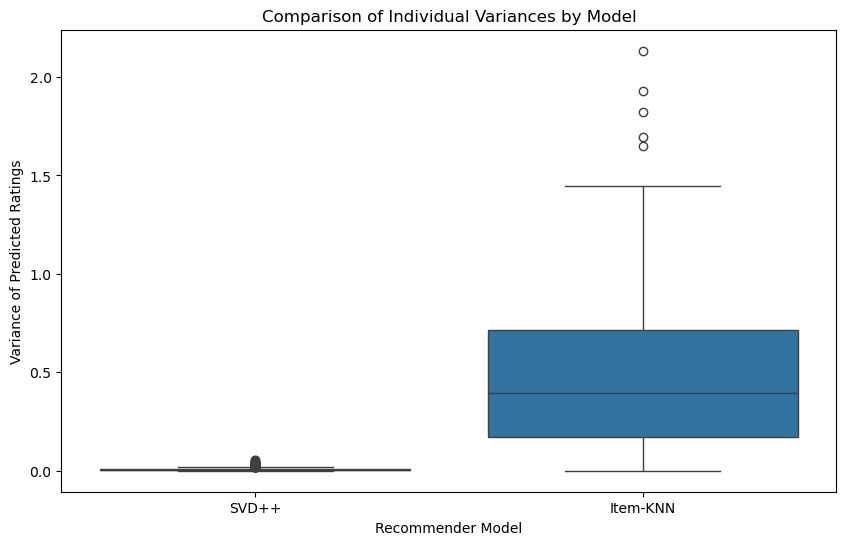

In [268]:
# Filter out customers with no predictions (variance=0 and count=0)
filtered_knn_df = knn_df[knn_df['Count'] > 0]
filtered_svd_df = svd_df[svd_df['Count'] > 0]

# Combine into one DataFrame for easier plotting
filtered_svd_df['Model'] = 'SVD++'
filtered_knn_df['Model'] = 'Item-KNN'
combined_df = pd.concat([filtered_svd_df, filtered_knn_df])

plt.figure(figsize=(10,6))
sns.boxplot(data=combined_df, x='Model', y='Variance')
plt.title('Comparison of Individual Variances by Model')
plt.ylabel('Variance of Predicted Ratings')
plt.xlabel('Recommender Model')
plt.show()

The plot shows the variance of predicted ratings and computes the spread (variance) of the top-5 predicted ratings per customer. As mentioned before, lower variance refers that the recommendations are more consistent per customer. It seems that SVD++ appears more individually fair based on the variance metric. The Item-KNN model shows more fluctuation in predicted scores within each user’s recommendations, which can imply less consistent treatment per user.

---
**2) Mean Average Envy for Individual Fairness:**
--

In [269]:
def calculate_individual_mean_average_envy(top_5_recommendations):
    """
    Calculates Mean Average Envy (MAE) for each customer based on their predicted ratings.
    Envy is defined as the average positive difference between the ratings of other customers
    and the focal customer's own rating for the same category.

    Parameters:
        top_5_recommendations (dict):
            Dictionary mapping customer IDs to a list of tuples (product_category, predicted_rating).

    Returns:
        dict: Dictionary mapping customer IDs to their MAE values.
              Format: {customer_id: mean_average_envy (float)}
    """
    individual_envy = {}
    customers = list(top_5_recommendations.keys())

    for customer_i in customers:
        recs_i = top_5_recommendations.get(customer_i, [])
        total_envy = 0
        comparisons = 0

        for category_i, rating_i in recs_i:
            # Compare against all other customers
            for customer_j in customers:
                if customer_i == customer_j:
                    continue
                recs_j = top_5_recommendations.get(customer_j, [])
                # Check ratings for the same category
                for category_j, rating_j in recs_j:
                    if category_j == category_i:
                        envy = max(rating_j - rating_i, 0)
                        total_envy += envy
                        comparisons += 1

        individual_envy[customer_i] = total_envy / comparisons if comparisons > 0 else 0.0

    return individual_envy

In [270]:
def group_envy_by_age(individual_envy, customer_demographics, age_key="age_group"):
    """
    Groups individual MAE values by customer age group.

    Parameters:
        individual_envy (dict):
            Dictionary mapping customer IDs to MAE values.
        customer_demographics (dict):
            Dictionary mapping customer IDs to their demographic information.
        age_key (str):
            Demographic attribute to group by age (default "age_group").

    Returns:
        list[dict]: List containing MAE data grouped by age, ready for DataFrame creation.
                    Format: [{"Age Group": str, "Customer ID": str, "Envy": float}, ...]
    """
    rows = []

    for customer, envy_value in individual_envy.items():
        demographics = customer_demographics.get(customer, {})
        age_group = demographics.get(age_key, "Unknown")

        rows.append({
            "Age Group": age_group,
            "Customer ID": customer,
            "Envy": envy_value
        })

    return rows

In [ ]:
# --- Generate Individual Envy from SVD++ recommendations ---
svd_individual_envy = calculate_individual_mean_average_envy(svd_top_5_recs)
svd_envy_rows = group_envy_by_age(svd_individual_envy, customer_demographics)

# Create DataFrame and sort
svd_envy_df = pd.DataFrame(svd_envy_rows).sort_values(by=["Age Group", "Customer ID"])

# Normalize dash formatting
svd_envy_df["Age Group"] = svd_envy_df["Age Group"].str.replace("–", "-", regex=False)

# Filter only for Age Group 18-25
svd_envy_18_25_df = svd_envy_df[svd_envy_df["Age Group"] == "18-25"]

# Display individual envy for Age Group 18-25 only
print("SVD++ Individual Envy – Age Group 18-25 (Example)")
print("================================================")

for _, row in svd_envy_18_25_df.iterrows():
    customer_id = row["Customer ID"]
    envy_value = row["Envy"]
    print(f"Customer ID: {customer_id}, Envy: {envy_value:.2f}")

SVD++ Individual Envy – Age Group 18-25 (Example)
Customer ID: 00-265-0556, Envy: 0.06
Customer ID: 00-275-9990, Envy: 0.01
Customer ID: 02-055-8248, Envy: 0.06
Customer ID: 02-677-6735, Envy: 0.11
Customer ID: 03-102-0288, Envy: 0.07
Customer ID: 03-977-8103, Envy: 0.03
Customer ID: 04-468-5487, Envy: 0.19
Customer ID: 04-809-8989, Envy: 0.06
Customer ID: 05-067-9686, Envy: 0.14
Customer ID: 05-167-0833, Envy: 0.06
Customer ID: 05-546-5128, Envy: 0.03
Customer ID: 05-857-1572, Envy: 0.06
Customer ID: 06-061-0023, Envy: 0.06
Customer ID: 06-160-8063, Envy: 0.01
Customer ID: 07-314-2945, Envy: 0.01
Customer ID: 07-751-9620, Envy: 0.05
Customer ID: 07-966-8728, Envy: 0.06
Customer ID: 08-584-8296, Envy: 0.06
Customer ID: 08-806-0588, Envy: 0.06
Customer ID: 09-775-4058, Envy: 0.08
Customer ID: 09-783-7921, Envy: 0.05
Customer ID: 09-948-3150, Envy: 0.06
Customer ID: 10-430-5821, Envy: 0.06
Customer ID: 11-820-5039, Envy: 0.06
Customer ID: 12-839-8066, Envy: 0.06
Customer ID: 13-571-6506,

In [272]:
# --- Generate Individual Envy from Item-KNN recommendations ---
knn_individual_envy = calculate_individual_mean_average_envy(knn_top_5_recs)
knn_envy_rows = group_envy_by_age(knn_individual_envy, customer_demographics)

# Create DataFrame and sort
knn_envy_df = pd.DataFrame(knn_envy_rows).sort_values(by=["Age Group", "Customer ID"])

# Normalize dashes in Age Group column
knn_envy_df["Age Group"] = knn_envy_df["Age Group"].str.replace("–", "-", regex=False)

# Filter only for Age Group 18-25
knn_envy_18_25_df = knn_envy_df[knn_envy_df["Age Group"] == "18-25"]

# Display individual envy for Age Group 18-25 only
print("Item-KNN Individual Envy – Age Group 18-25 (Example)")
print("====================================================")

for _, row in knn_envy_18_25_df.iterrows():
    customer_id = row["Customer ID"]
    envy_value = row["Envy"]
    print(f"Customer ID: {customer_id}, Envy: {envy_value:.2f}")

Item-KNN Individual Envy – Age Group 18-25 (Example)
Customer ID: 00-265-0556, Envy: 0.00
Customer ID: 00-275-9990, Envy: 0.00
Customer ID: 02-055-8248, Envy: 0.00
Customer ID: 02-677-6735, Envy: 0.00
Customer ID: 03-102-0288, Envy: 0.00
Customer ID: 03-977-8103, Envy: 0.00
Customer ID: 04-468-5487, Envy: 0.00
Customer ID: 04-809-8989, Envy: 0.00
Customer ID: 05-067-9686, Envy: 0.00
Customer ID: 05-167-0833, Envy: 0.00
Customer ID: 05-546-5128, Envy: 0.00
Customer ID: 05-857-1572, Envy: 0.00
Customer ID: 06-061-0023, Envy: 0.00
Customer ID: 06-160-8063, Envy: 0.00
Customer ID: 07-314-2945, Envy: 0.00
Customer ID: 07-751-9620, Envy: 0.00
Customer ID: 07-966-8728, Envy: 0.00
Customer ID: 08-584-8296, Envy: 0.65
Customer ID: 08-806-0588, Envy: 0.00
Customer ID: 09-775-4058, Envy: 0.00
Customer ID: 09-783-7921, Envy: 0.00
Customer ID: 09-948-3150, Envy: 0.00
Customer ID: 10-430-5821, Envy: 0.00
Customer ID: 11-820-5039, Envy: 0.00
Customer ID: 12-839-8066, Envy: 0.00
Customer ID: 13-571-65

SVD++: 0 customers with zero envy removed.
Item-KNN: 789 customers with zero envy removed.


C:\Users\vahav\AppData\Local\Temp\ipykernel_2128\2997050371.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_knn_envy_df['Model'] = 'Item-KNN'


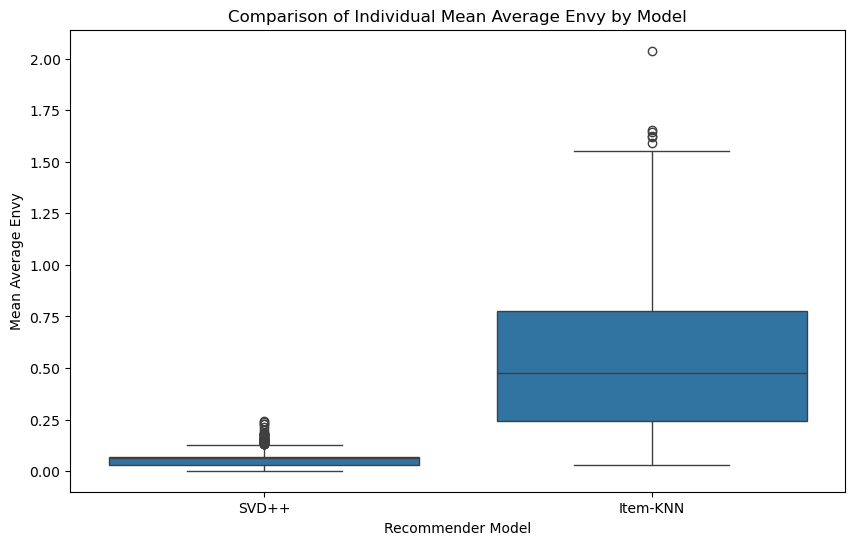

In [273]:
# Identify and filter out customers with no predictions (Envy=0 due to no comparisons)
filtered_svd_envy_df = svd_envy_df[svd_envy_df['Envy'] > 0]
filtered_knn_envy_df = knn_envy_df[knn_envy_df['Envy'] > 0]

# Clearly state how many customers were removed (optional but recommended for transparency)
print(f"SVD++: {len(svd_envy_df) - len(filtered_svd_envy_df)} customers with zero envy removed.")
print(f"Item-KNN: {len(knn_envy_df) - len(filtered_knn_envy_df)} customers with zero envy removed.")

# Combine envy data into one filtered DataFrame for accurate visualization
filtered_svd_envy_df['Model'] = 'SVD++'
filtered_knn_envy_df['Model'] = 'Item-KNN'
filtered_combined_envy_df = pd.concat([filtered_svd_envy_df, filtered_knn_envy_df])

# Create boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_combined_envy_df, x='Model', y='Envy')
plt.title('Comparison of Individual Mean Average Envy by Model')
plt.ylabel('Mean Average Envy')
plt.xlabel('Recommender Model')
plt.show()

The boxplot visualizes the distribution of envy values per customer, comparing how much, on average, each customer envies others’ recommendations (i.e., how much better others are treated in terms of predicted ratings). Mean Average Envy (MAE) is calculated per user by comparing their top-5 predictions with those of other users for shared items. Lower MAE → user perceives less disparity in treatment → higher individual fairness. From the plot we can see that Item-KNN shows much more variability and higher envy, indicating it is less individually fair.

---
---
**Group User Fairness**
---
To evaluate group fairness in the recommender systems, four complementary fairness metrics are applied across various demographic attributes (gender, age, income and education level and sarital status). Each metric captures a different dimension of fairness in predicted satisfaction.

1) **Variance** captures how consistent the predicted ratings are for users within a demographic group across product categories. A fair recommender should treat users in the same group similarly (e.g., same gender or age group). Lower vairance refers to a fairer system (more consistency for that group).It is computed as follows:
    - Group customers by demographic attribute (e.g. gender_female)
    - For each product category, collect all predicted ratings from users in that group.
    - Compute the variance of those ratings.
    - Average variances across all categories → gives one fairness score per group.

2) **Mean Average Envy (MAE)** quantifies how much users in a demographic group might envy recommendations given to others in the same group. A fair model should make all users feel their recommendations are not worse than others in their dempgraphical attribute group. Lower envy → users aren’t disadvantaged compared to their peers → fairer system. Within each demographic group (e.g., gender_female), it:
    - Compares all pairs of users who received recommendations for the same category within each demographic group (e.g. gender_female)
    - For each pair (comparison): calculatete envy:
        - Envy 𝑖 → 𝑗 = max(Rating 𝑗 − Rating 𝑖, 0)
            - If user j got a better rating than i, user i envies that.
    - All envy values are summed and averaged over the number of comparisons.
    - The final output is the mean average envy per group.

3) **Absolute Difference (AD)** captures the difference in average predicted satisfaction between a rotected group (females) and an unprotected group (males). These groups were selected to showcase for the metric works, but tehy could also be e.g. active users and inactive users. A fair model should not favor one group over another in terms of average predicted rating. Lower AD indicates smaller disparity (gap) between protected and unprotected groups → more equal (fair) treatment across groups. This is computes as:
    - For each product category, seperate predicted ratings by gender
    - Compute: AD category = ∣average rating of the unprotected group − average rating of the protected group∣
    - Average across all categories for an overall fairness score.

4) **Fraction of Satisfied Users (FSU)** reflects how many users in a group are at least as satisfied as the group's average, based on predicted ratings. If most users in a group feel they are at or above the group norm, that suggests equitable treatment. Higher satisfaction means that more users in that group receive recommendations they are likely to appriciate → more equitable satisfaction. It is computes as follows:
    - Compute each user's average predicted rating (i.e. their "utility").
    - Calculate the average utility for their group.
    - Mark user as "satisfied" if their average utility is ≥ group average.
    - Count the fraction of satisfied users in each group by summing satisfied customers and dividing by the group total.




---
**1) Variance for Group Fairness:**
---

Measuring the consistency within a group.

Function for calculating the variance within each demographic group for each product category:

In [274]:
def calculate_group_variances(top_5_recommendations, customer_demographics, demographic_columns, product_categories):
    """
    Calculates variance in predicted ratings for each demographic group across product categories.

    Parameters:
        top_5_recommendations (dict):
            Dictionary mapping customer IDs to lists of tuples (category, predicted_rating).
        customer_demographics (dict):
            Dictionary mapping customer IDs to their demographic attributes.
        demographic_columns (list[str]):
            List of demographic attributes (e.g., ['gender', 'age_group']).
        product_categories (list[str]):
            List of product categories.

    Returns:
        dict: Nested dictionary structured as follows:
            {
                'gender_Male': {
                    'Category1': {'variance': float, 'count': int},
                    'Category2': {'variance': float, 'count': int}, ...
                },
                ...
            }
    """
    group_stats = defaultdict(lambda: defaultdict(dict))

    # Group customers based on demographics
    demographic_groups = {
        col: defaultdict(list) for col in demographic_columns
    }
    for customer_id, demographics in customer_demographics.items():
        for col in demographic_columns:
            group_value = demographics.get(col, "Unknown")
            demographic_groups[col][group_value].append(customer_id)

    # Calculate variance per group per category
    for col, groups in demographic_groups.items():
        for group_value, customers in groups.items():
            group_key = f"{col}_{group_value}"
            for category in product_categories:
                ratings = [
                    rating
                    for customer in customers
                    for cat, rating in top_5_recommendations.get(customer, [])
                    if cat == category
                ]
                variance = np.var(ratings) if ratings else 0.0
                count = len(ratings)

                group_stats[group_key][category] = {
                    "variance": variance,
                    "count": count
                }

    return group_stats

In [275]:
def analyze_group_variances(group_stats):
    """
    Computes the average variance across all categories for each demographic group and sorts groups by average variance.

    Parameters:
        group_stats (dict):
            Output dictionary from `calculate_group_variances`.

    Returns:
        list[tuple]: Sorted list of groups based on average variance.
            Format: [(group_key, {'avg_variance': float, 'total_count': int}), ...]
    """
    group_analysis = []

    for group_key, category_stats in group_stats.items():
        variances = [stats['variance'] for stats in category_stats.values()]
        total_count = sum(stats['count'] for stats in category_stats.values())
        avg_variance = np.mean(variances) if variances else 0.0

        group_analysis.append(
            (group_key, {"avg_variance": avg_variance, "total_count": total_count})
        )

    # Sort groups descendingly by average variance
    sorted_groups = sorted(
        group_analysis,
        key=lambda x: x[1]["avg_variance"],
        reverse=True
    )

    return sorted_groups

In [276]:
# Calculate variances for demographic groups (SVD++)
svd_group_stats = calculate_group_variances(
    svd_top_5_recs,
    customer_demographics,
    ['gender', 'age_group', 'income_level', 'education_level', 'occupation', 'marital_status'],
    list(user_item_matrix.index)
)

# Analyze and sort groups
sorted_svd_groups = analyze_group_variances(svd_group_stats)

# Display only the first 5 groups as an example
print("Groups with Highest Average Variance (SVD++ Recommendations) – Example")
print("=" * 70)
for group, stats in sorted_svd_groups[:5]:
    print(f"Group: {group}")
    print(f"Average Variance:  {stats['avg_variance']:.2f}")
    print(f"Total Predictions: {stats['total_count']}")
    print("-" * 50)

Groups with Highest Average Variance (SVD++ Recommendations) – Example
Group: occupation_Middle
Average Variance:  0.01
Total Predictions: 2415
--------------------------------------------------
Group: marital_status_Single
Average Variance:  0.01
Total Predictions: 1210
--------------------------------------------------
Group: gender_Male
Average Variance:  0.01
Total Predictions: 2245
--------------------------------------------------
Group: income_level_Middle
Average Variance:  0.01
Total Predictions: 2425
--------------------------------------------------
Group: income_level_High
Average Variance:  0.01
Total Predictions: 2575
--------------------------------------------------


In [277]:
# Calculate variances for demographic groups (Item-KNN)
knn_group_stats = calculate_group_variances(
    knn_top_5_recs,
    customer_demographics,
    ['gender', 'age_group', 'income_level', 'education_level', 'occupation', 'marital_status'],
    list(user_item_matrix.index)
)

# Analyze and sort groups
sorted_knn_groups = analyze_group_variances(knn_group_stats)

# Display only the first 5 groups as an example
print("\nGroups with Highest Average Variance (Item-KNN Recommendations) – Example")
print("=" * 70)
for group, stats in sorted_knn_groups[:5]:
    print(f"Group: {group}")
    print(f"Average Variance:  {stats['avg_variance']:.2f}")
    print(f"Total Predictions: {stats['total_count']}")
    print("-" * 50)


Groups with Highest Average Variance (Item-KNN Recommendations) – Example
Group: gender_Female
Average Variance:  0.97
Total Predictions: 360
--------------------------------------------------
Group: occupation_Middle
Average Variance:  0.97
Total Predictions: 359
--------------------------------------------------
Group: education_level_Master's
Average Variance:  0.95
Total Predictions: 225
--------------------------------------------------
Group: marital_status_Widowed
Average Variance:  0.95
Total Predictions: 176
--------------------------------------------------
Group: occupation_High
Average Variance:  0.94
Total Predictions: 371
--------------------------------------------------


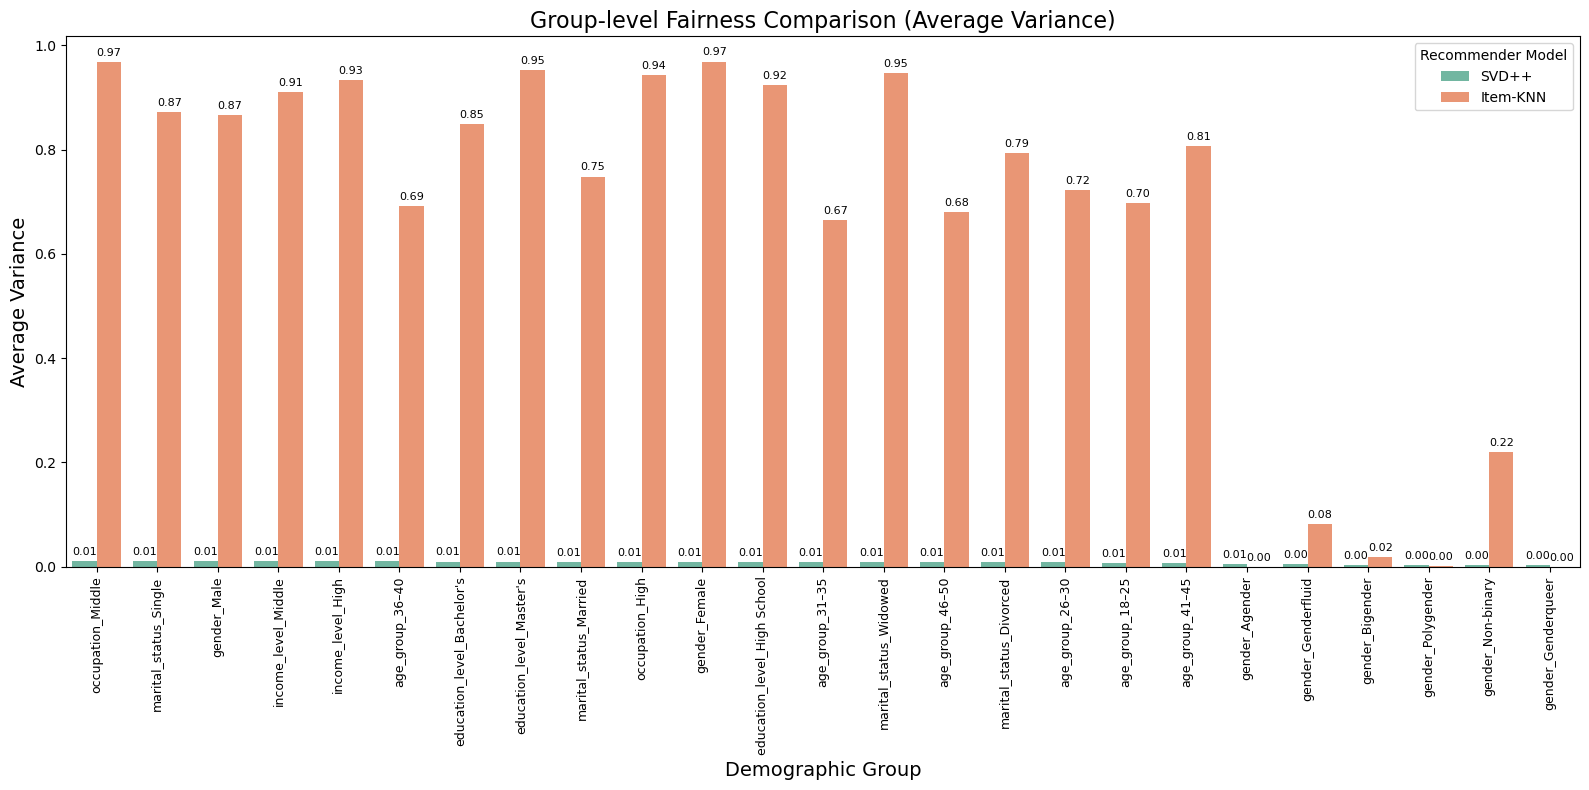

In [278]:
# --- Convert group-level variance data to DataFrames ---
svd_group_df = pd.DataFrame([
    {'Group': g, 'Avg_Variance': stats['avg_variance'], 'Total_Predictions': stats['total_count']}
    for g, stats in sorted_svd_groups
])

knn_group_df = pd.DataFrame([
    {'Group': g, 'Avg_Variance': stats['avg_variance'], 'Total_Predictions': stats['total_count']}
    for g, stats in sorted_knn_groups
])

# Add a column to distinguish between models
svd_group_df['Model'] = 'SVD++'
knn_group_df['Model'] = 'Item-KNN'

# Combine DataFrames for visualization
combined_group_df = pd.concat([svd_group_df, knn_group_df])

# --- Visualize group-level fairness with a bar plot ---
plt.figure(figsize=(16, 8))
ax = sns.barplot(
    data=combined_group_df,
    x='Group',
    y='Avg_Variance',
    hue='Model',
    palette ='Set2'
)

# Annotate each bar with its value
for container in ax.containers:
    ax.bar_label(
        container,
        fmt='%.2f',
        label_type='edge',
        fontsize=8,
        padding=3
    )

# Improve layout readability
plt.title('Group-level Fairness Comparison (Average Variance)', fontsize=16)
plt.xlabel('Demographic Group', fontsize=14)
plt.ylabel('Average Variance', fontsize=14)
plt.xticks(rotation=90, ha='center', fontsize=9)
plt.legend(title='Recommender Model')
plt.tight_layout()
plt.show()

From the plot above we can see the average variance of predicted ratings across customers in a specific demographical group. As mentioned before, in context of fairness, lower variance means more consistency in recommendations for that group. The plot shows that the SVD++ model is more consistent in its predictions across demographic groups, indicating it’s likely a more group-fair model. Item-KNN shows wider disparity, meaning different customer within the same group receive much more varied recommendations—raising fairness concerns. Some variance might be justified (e.g., from genuine preference differences), but inconsistent treatment of similar users often violates fairness principles.

In [279]:
print("\nGroups with Highest Variance (Top 10):")
print("SVD++ model:")
print(svd_group_df.sort_values(by='Avg_Variance', ascending=False).head(5))

print("\nItem-KNN model:")
print(knn_group_df.sort_values(by='Avg_Variance', ascending=False).head(5))


Groups with Highest Variance (Top 10):
SVD++ model:
                   Group  Avg_Variance  Total_Predictions  Model
0      occupation_Middle      0.011009               2415  SVD++
1  marital_status_Single      0.010916               1210  SVD++
2            gender_Male      0.010742               2245  SVD++
3    income_level_Middle      0.010595               2425  SVD++
4      income_level_High      0.010120               2575  SVD++

Item-KNN model:
                      Group  Avg_Variance  Total_Predictions     Model
0             gender_Female      0.968629                360  Item-KNN
1         occupation_Middle      0.967023                359  Item-KNN
2  education_level_Master's      0.952045                225  Item-KNN
3    marital_status_Widowed      0.945799                176  Item-KNN
4           occupation_High      0.943236                371  Item-KNN


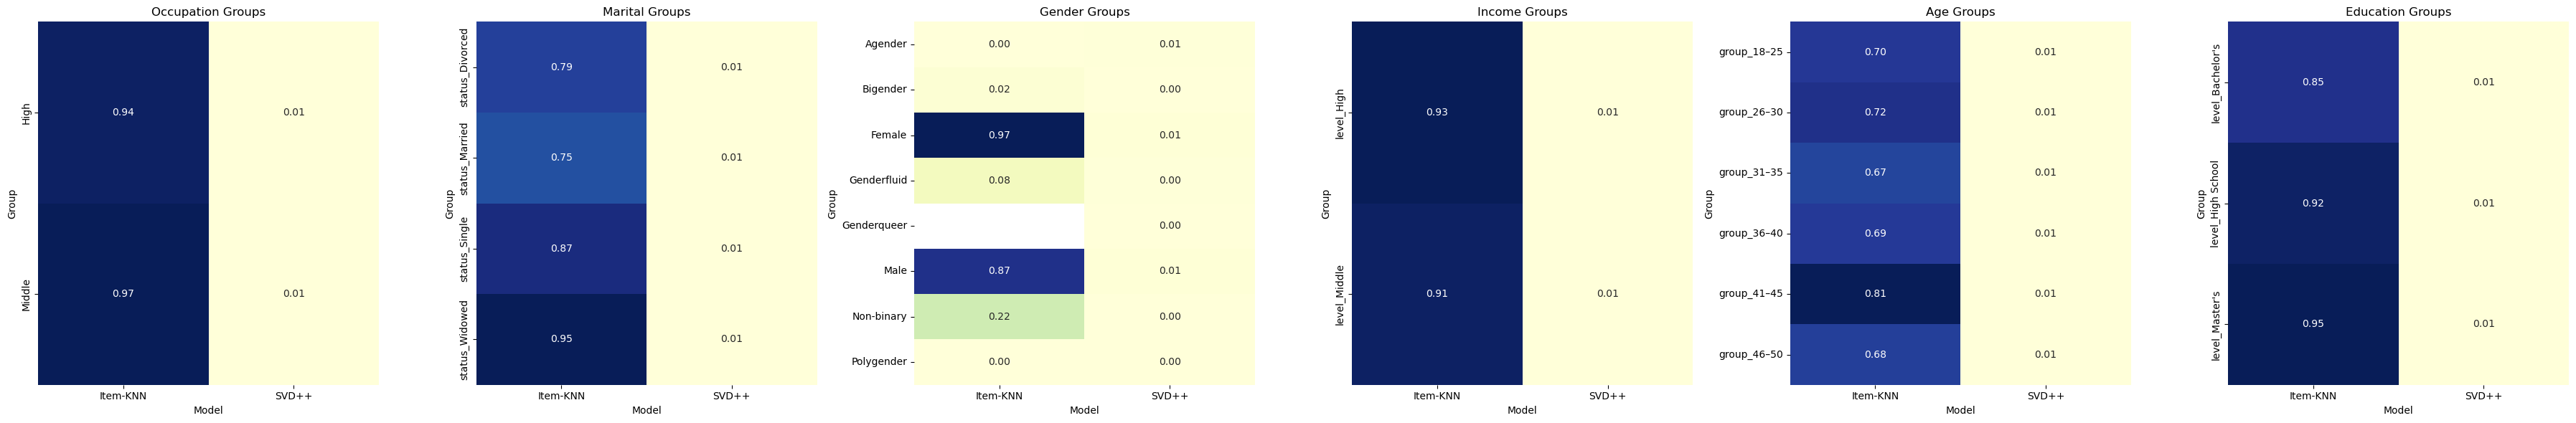

In [280]:
# Convert variance dictionaries into DataFrames
svd_var_df = pd.DataFrame([
    {'Group': group, 'Model': 'SVD++', 'Variance': stats['avg_variance']}
    for group, stats in sorted_svd_groups
])

knn_var_df = pd.DataFrame([
    {'Group': group, 'Model': 'Item-KNN', 'Variance': stats['avg_variance']}
    for group, stats in sorted_knn_groups
])

# Combine into a single DataFrame
variance_df = pd.concat([svd_var_df, knn_var_df])

# Optional: Filter out groups with zero variance
variance_df = variance_df[variance_df['Variance'] > 0]

# Split group name into demographic type and value
variance_df[['Demographic', 'Value']] = variance_df['Group'].str.split('_', n=1, expand=True)

# Get unique demographic types
demographic_types = variance_df['Demographic'].unique()
n = len(demographic_types)

# Create side-by-side subplots
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(6 * n, 6), squeeze=False)

for idx, demo_col in enumerate(demographic_types):
    demo_data = variance_df[variance_df['Demographic'] == demo_col]
    heatmap_data = demo_data.pivot(index='Value', columns='Model', values='Variance')

    ax = axes[0, idx]
    sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".2f", ax=ax, cbar=False)
    ax.set_title(f"{demo_col.capitalize()} Groups")
    ax.set_xlabel("Model")
    ax.set_ylabel("Group")

plt.tight_layout()
plt.show()

Each heatmap represents a demographic dimension (like Age, Gender, Income, etc.), with: Y-axis: Groups within that demographic (e.g., "18–25", "Female", "Middle income"), X-axis: The recommender models (SVD++ and Item-KNN), Cell values: Average variance of predicted ratings for that group and model, and Color gradient: Darker means higher variance (worse consistency/fairness).

Across all demographic groups, SVD++ shows lighter-colored cells and lower numerical values than Item-KNN. This suggests SVD++ is consistently fairer across groups, offering more uniform predictions. KNN produces high variance (dark blue cells), which indicates the recommendations are more uneven within those groups.




---
**2) Mean Average Envy (MAE) for Group Fairness:**
---
Measuring fairness relative to peers in the same group.

In [281]:
def calculate_group_envy(top_5_recommendations, customer_demographics, demographic_columns, product_categories):
    """
    Calculates total envy scores for each demographic group and each product category.
    Envy is computed by summing positive rating differences within customer pairs in the same demographic group.

    Parameters:
        top_5_recommendations (dict):
            Dictionary mapping customer IDs to lists of tuples (category, predicted_rating).
        customer_demographics (dict):
            Dictionary mapping customer IDs to their demographic attributes.
        demographic_columns (list[str]):
            List of demographic attributes to group by (e.g., ['gender', 'age_group']).
        product_categories (list[str]):
            List of product categories.

    Returns:
        dict: Nested dictionary of total envy values structured as:
            { 'demographic_group': { 'category': total_envy_value, ... }, ... }
    """
    group_envy = defaultdict(lambda: defaultdict(float))

    # Group customers by demographics
    demographic_groups = {col: defaultdict(list) for col in demographic_columns}
    for customer_id, demographics in customer_demographics.items():
        for col in demographic_columns:
            group_value = demographics.get(col, "Unknown")
            demographic_groups[col][group_value].append(customer_id)

    # Calculate envy within each demographic group
    for col, groups in demographic_groups.items():
        for group_value, customers in groups.items():
            group_key = f"{col}_{group_value}"
            for idx_i, customer_i in enumerate(customers):
                recs_i = top_5_recommendations.get(customer_i, [])
                for customer_j in customers[idx_i + 1:]:
                    recs_j = top_5_recommendations.get(customer_j, [])
                    # Compare ratings for the same categories
                    for cat_i, rating_i in recs_i:
                        for cat_j, rating_j in recs_j:
                            if cat_i == cat_j:
                                envy_ij = max(rating_j - rating_i, 0)
                                envy_ji = max(rating_i - rating_j, 0)
                                group_envy[group_key][cat_i] += envy_ij + envy_ji
    return group_envy

Total envy for SVD++ and ItemKNN models:

In [282]:
svd_group_envy_values = calculate_group_envy(
    svd_top_5_recs, 
    customer_demographics, 
    ['gender', 'age_group', 'income_level', 'education_level', 'occupation', 'marital_status'], 
    list(user_item_matrix.index)
)

knn_group_envy_values = calculate_group_envy(
    knn_top_5_recs, 
    customer_demographics, 
    ['gender', 'age_group', 'income_level', 'education_level', 'occupation', 'marital_status'], 
    list(user_item_matrix.index)
)

Function to calculate Mean Average Envy (MAE) for each demographic group:

In [283]:
def calculate_group_mae(group_envy, customer_demographics, demographic_columns):
    """
    Calculates Mean Average Envy (MAE) per demographic group, averaging total envy across all comparisons.

    Parameters:
        group_envy (dict):
            Nested dictionary containing total envy per group and category.
        customer_demographics (dict):
            Dictionary mapping customer IDs to demographic attributes.
        demographic_columns (list[str]):
            List of demographic attributes used for grouping.

    Returns:
        dict: Dictionary mapping each demographic group to their MAE value.
              Format: {'demographic_group': MAE_value, ...}
    """
    mae_by_group = {}
    
    # Compute group sizes for envy normalization
    demographic_groups = {col: defaultdict(list) for col in demographic_columns}
    for customer_id, demographics in customer_demographics.items():
        for col in demographic_columns:
            group_value = demographics.get(col, "Unknown")
            demographic_groups[col][group_value].append(customer_id)

    for col, groups in demographic_groups.items():
        for group_value, customers in groups.items():
            group_key = f"{col}_{group_value}"
            num_customers = len(customers)
            num_comparisons = num_customers * (num_customers - 1)  # All possible pairs (both directions)
            
            total_group_envy = sum(group_envy.get(group_key, {}).values())
            mae = total_group_envy / num_comparisons if num_comparisons > 0 else 0.0
            mae_by_group[group_key] = mae
    
    return mae_by_group

MAE for the SVD++ model:

In [284]:
svd_group_mae_values = calculate_group_mae(
    svd_group_envy_values, 
    customer_demographics, 
    ['gender', 'age_group', 'income_level', 'education_level', 'occupation', 'marital_status']
)

print("\nMean Average Envy (MAE) per Group (SVD++):")
print("-" * 45)
for group, mae in svd_group_mae_values.items():
    print(f"{group}: {mae:.2f}")


Mean Average Envy (MAE) per Group (SVD++):
---------------------------------------------
gender_Female: 0.18
gender_Male: 0.18
gender_Bigender: 0.15
gender_Genderfluid: 0.19
gender_Non-binary: 0.18
gender_Polygender: 0.16
gender_Agender: 0.20
gender_Genderqueer: 0.19
age_group_18–25: 0.18
age_group_46–50: 0.18
age_group_26–30: 0.18
age_group_31–35: 0.18
age_group_41–45: 0.17
age_group_36–40: 0.19
income_level_Middle: 0.19
income_level_High: 0.17
education_level_Bachelor's: 0.18
education_level_High School: 0.17
education_level_Master's: 0.18
occupation_Middle: 0.18
occupation_High: 0.18
marital_status_Married: 0.19
marital_status_Single: 0.18
marital_status_Widowed: 0.17
marital_status_Divorced: 0.18


MAE for the ItemKNN model:

In [285]:
knn_group_mae_values = calculate_group_mae(
    knn_group_envy_values, 
    customer_demographics, 
    ['gender', 'age_group', 'income_level', 'education_level', 'occupation', 'marital_status']
)

print("\nMean Average Envy (MAE) per Group (Item-KNN):")
print("-" * 45)
for group, mae in knn_group_mae_values.items():
    print(f"{group}: {mae:.2f}")


Mean Average Envy (MAE) per Group (Item-KNN):
---------------------------------------------
gender_Female: 0.01
gender_Male: 0.01
gender_Bigender: 0.00
gender_Genderfluid: 0.02
gender_Non-binary: 0.02
gender_Polygender: 0.00
gender_Agender: 0.00
gender_Genderqueer: 0.00
age_group_18–25: 0.02
age_group_46–50: 0.02
age_group_26–30: 0.01
age_group_31–35: 0.01
age_group_41–45: 0.01
age_group_36–40: 0.01
income_level_Middle: 0.01
income_level_High: 0.01
education_level_Bachelor's: 0.02
education_level_High School: 0.01
education_level_Master's: 0.01
occupation_Middle: 0.01
occupation_High: 0.01
marital_status_Married: 0.02
marital_status_Single: 0.01
marital_status_Widowed: 0.01
marital_status_Divorced: 0.01


Comparing the results to define which model is more fair:

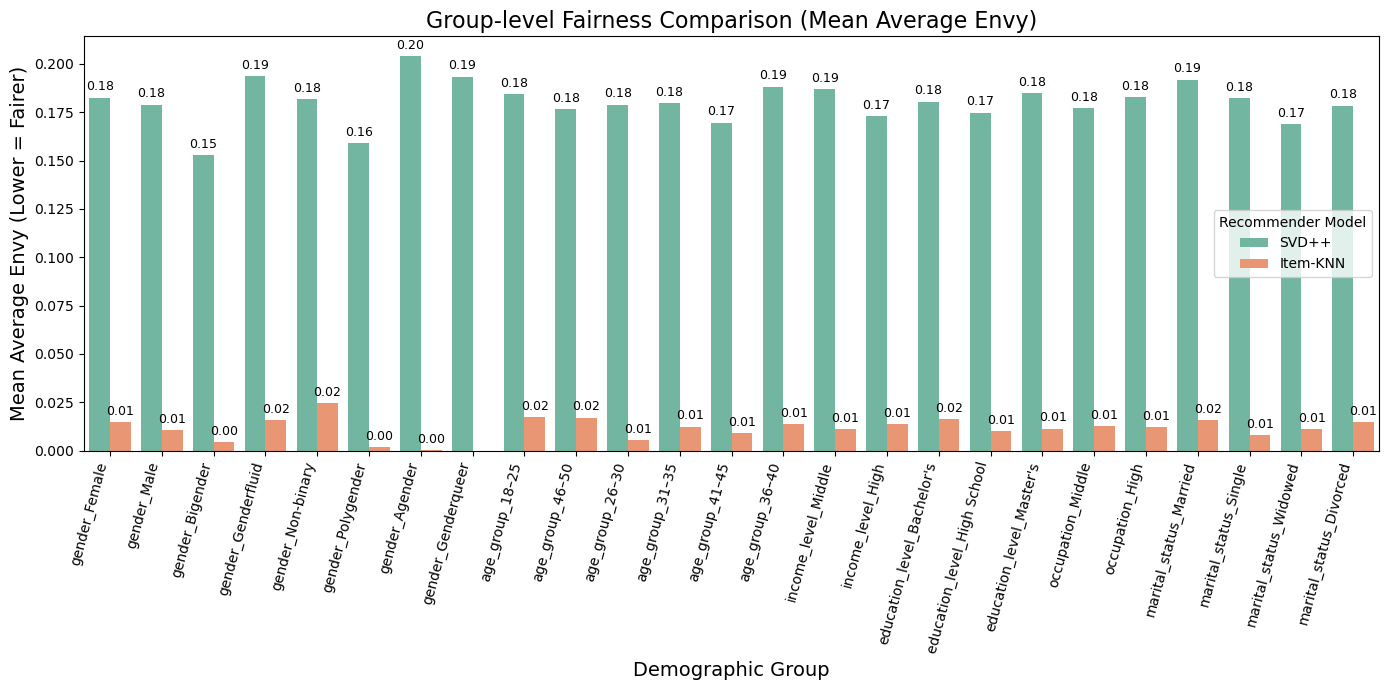

In [286]:
# --- Convert your group-level MAE results into DataFrames ---
svd_group_mae_df = pd.DataFrame([
    {'Group': group, 'MAE': mae}
    for group, mae in svd_group_mae_values.items()
])

knn_group_mae_df = pd.DataFrame([
    {'Group': group, 'MAE': mae}
    for group, mae in knn_group_mae_values.items()
])

# Label the models
svd_group_mae_df['Model'] = 'SVD++'
knn_group_mae_df['Model'] = 'Item-KNN'

# Combine both model results
combined_mae_df = pd.concat([svd_group_mae_df, knn_group_mae_df])

# Optional: Filter out zero MAE values (usually due to no comparisons)
filtered_combined_mae_df = combined_mae_df[combined_mae_df['MAE'] > 0]

# --- Plotting ---
plt.figure(figsize=(14, 7))
barplot = sns.barplot(
    data=filtered_combined_mae_df,
    x='Group',
    y='MAE',
    hue='Model',
    palette='Set2'
)

# Add actual MAE values to bars
for p in barplot.patches:
    height = p.get_height()
    if height > 0:
        barplot.annotate(f'{height:.2f}',
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom',
                         fontsize=9, color='black', xytext=(0, 3),
                         textcoords='offset points')

# Formatting
plt.title('Group-level Fairness Comparison (Mean Average Envy)', fontsize=16)
plt.xlabel('Demographic Group', fontsize=14)
plt.ylabel('Mean Average Envy (Lower = Fairer)', fontsize=14)
plt.xticks(rotation=75, ha='right')
plt.legend(title='Recommender Model')
plt.tight_layout()

# Show plot
plt.show()

From the plot above, shows a bar plot of mean average envy by demographical groups. Here, lower the value, fairer the system. The SVD++ model is better at providing balanced recommendations across user groups, minimizing the perceived "envy" between users in the same group.

<Axes: xlabel='MAE', ylabel='Group'>

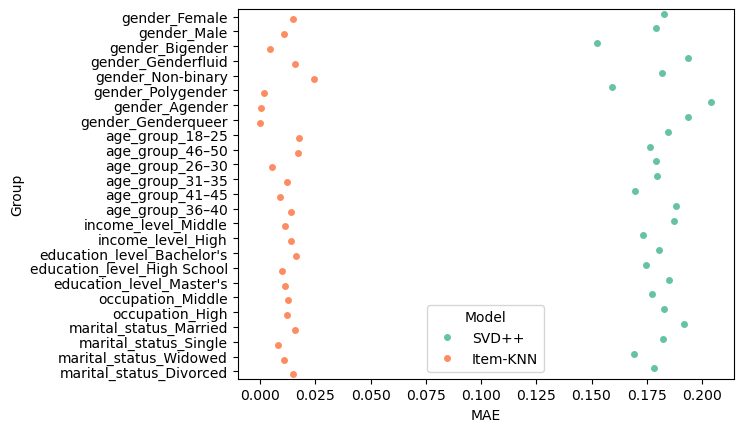

In [287]:
sns.stripplot(data=combined_mae_df, x='MAE', y='Group', hue='Model', palette='Set2', dodge=True)

This plot gives a clearer look at the MAE spread per group using dots instead of bars. Here each dot represents the MAE for one model/group combination. The dots for Item-KNN are farther to the right, meaning more envy. SVD++ dots cluster tightly around the low MAE values, confirming greater fairness.

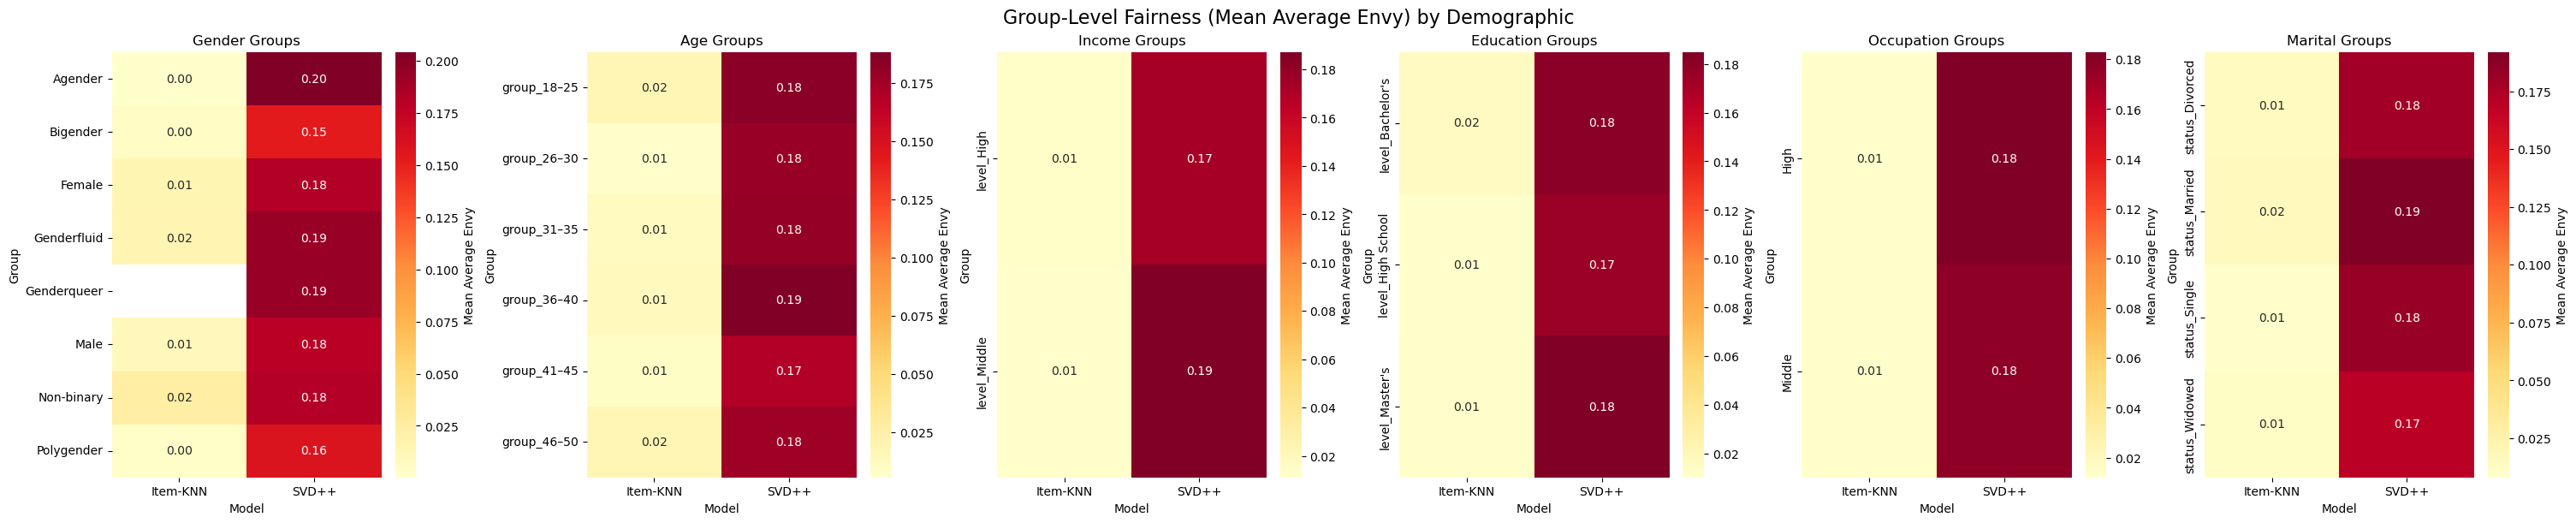

In [288]:
# Convert MAE dictionaries into DataFrames
svd_mae_df = pd.DataFrame([
    {'Group': group, 'Model': 'SVD++', 'MAE': mae}
    for group, mae in svd_group_mae_values.items()
])

knn_mae_df = pd.DataFrame([
    {'Group': group, 'Model': 'Item-KNN', 'MAE': mae}
    for group, mae in knn_group_mae_values.items()
])

# Combine both into one DataFrame
mae_df = pd.concat([svd_mae_df, knn_mae_df])

# Optional: filter out groups with MAE = 0
mae_df = mae_df[mae_df['MAE'] > 0]

# Split group name into demographic type and value
mae_df[['Demographic', 'Value']] = mae_df['Group'].str.split('_', n=1, expand=True)

# Identify unique demographic types
demographics = mae_df['Demographic'].unique()
n_demos = len(demographics)

# Set up subplots
fig, axes = plt.subplots(1, n_demos, figsize=(5 * n_demos, 6), constrained_layout=True)

# Loop through each demographic and plot side-by-side
for i, demo_col in enumerate(demographics):
    ax = axes[i]
    demo_data = mae_df[mae_df['Demographic'] == demo_col]
    heatmap_data = demo_data.pivot(index='Value', columns='Model', values='MAE')

    sns.heatmap(
        heatmap_data,
        annot=True,
        cmap='YlOrRd',
        fmt=".2f",
        cbar_kws={'label': 'Mean Average Envy'},
        ax=ax
    )
    ax.set_title(f"{demo_col.capitalize()} Groups", fontsize=12)
    ax.set_xlabel("Model")
    ax.set_ylabel("Group")

plt.suptitle("Group-Level Fairness (Mean Average Envy) by Demographic", fontsize=16)
plt.show()

The heatmaps illustrate a clear fairness advantage for the Item-KNN model when evaluated using the Mean Average Envy (MAE) metric. Across all demographic categories—gender, age, income, education, occupation, and marital status—Item-KNN yields consistently lower MAE, suggesting more equitable and envy-free recommendations. In contrast, SVD++ recommendations result in significantly higher envy, indicating fairness concerns within user groups.

---
**3) Absolute Difference (AD) for Group Fairness:**
---
Measuring the disparity between two groups (female and male)

In [289]:
def calculate_absolute_difference(predictions, customer_demographics, product_categories, gender_key="gender"):
    """
    Calculates Absolute Difference (AD) in predicted ratings between protected (female) 
    and unprotected (male) groups for each product category.

    Parameters:
        predictions (dict):
            Dictionary mapping customer IDs to a list of (category, predicted_rating) tuples.
        customer_demographics (dict):
            Dictionary mapping customer IDs to demographic attributes, including gender.
        product_categories (list):
            List of product categories to evaluate.
        gender_key (str):
            Key in demographic dict for gender. Default is "gender".

    Returns:
        dict: Mapping from product category to AD value (float), or None if one group is missing.
              Format: {category: abs_diff_value or None}
    """
    ad_by_category = {}

    for category in product_categories:
        ratings_male = []
        ratings_female = []

        for customer, recs in predictions.items():
            gender = customer_demographics.get(customer, {}).get(gender_key, "unknown").lower()
            if gender not in {"male", "female"}:
                continue

            for cat, rating in recs:
                if cat == category:
                    if gender == "male":
                        ratings_male.append(rating)
                    elif gender == "female":
                        ratings_female.append(rating)

        if ratings_male and ratings_female:
            avg_male = np.mean(ratings_male)
            avg_female = np.mean(ratings_female)
            ad_by_category[category] = abs(avg_male - avg_female)
        else:
            ad_by_category[category] = None  # Not enough data for comparison

    return ad_by_category

In [290]:
def create_ad_comparison_df(svd_ad_dict, knn_ad_dict):
    """
    Combines AD values from both models into a single DataFrame for side-by-side comparison.

    Parameters:
        svd_ad_dict (dict): AD values from SVD++ model.
        knn_ad_dict (dict): AD values from Item-KNN model.

    Returns:
        DataFrame: Columns include product category, AD for each model.
    """
    all_categories = sorted(set(svd_ad_dict.keys()) | set(knn_ad_dict.keys()))

    df = pd.DataFrame({
        "Product Category": all_categories,
        "SVD++ AD": [svd_ad_dict.get(cat) for cat in all_categories],
        "Item-KNN AD": [knn_ad_dict.get(cat) for cat in all_categories]
    })

    return df

In [291]:
def compute_average_ad(ad_dict):
    """
    Compute the average Absolute Difference (AD) across product categories,
    excluding those with missing (None) values.

    Parameters:
        ad_dict (dict): Dictionary mapping category -> AD value (or None).

    Returns:
        float: Mean AD value (overall group fairness score).
    """
    valid_ads = [val for val in ad_dict.values() if val is not None]
    return np.mean(valid_ads) if valid_ads else None

# Define product categories (from user-item matrix index)
product_categories = list(user_item_matrix.index)

# Compute AD for SVD++ model
svd_ad = calculate_absolute_difference(
    svd_top_5_recs, 
    customer_demographics, 
    product_categories,
    gender_key="gender"
)

# Compute AD for Item-KNN model
knn_ad = calculate_absolute_difference(
    knn_top_5_recs, 
    customer_demographics, 
    product_categories,
    gender_key="gender"
)

# Create side-by-side comparison DataFrame
ad_df = create_ad_comparison_df(svd_ad, knn_ad)

# Compute model-level average AD
svd_avg_ad = compute_average_ad(svd_ad)
knn_avg_ad = compute_average_ad(knn_ad)

print(f"\nOverall Fairness (Average AD across categories):")
print(f"SVD++:   {svd_avg_ad:.4f}")
print(f"Item-KNN: {knn_avg_ad:.4f}")
print(f"")
# Print results
print("Absolute Difference (AD) Fairness Metrics by Product Category:")
print(ad_df.to_string(index=False))


Overall Fairness (Average AD across categories):
SVD++:   0.0373
Item-KNN: 0.3413

Absolute Difference (AD) Fairness Metrics by Product Category:
         Product Category  SVD++ AD  Item-KNN AD
              Animal Feed  0.034418     0.210319
            Arts & Crafts  0.047097     0.204226
            Baby Products  0.006537     0.826667
   Beauty & Personal Care  0.015108     0.719445
                    Books       NaN     0.095001
                 Clothing  0.013159     0.649999
              Electronics  0.003449     0.248180
         Food & Beverages  0.056980     0.571429
                Furniture  0.013926     0.229556
     Gardening & Outdoors       NaN     0.191996
                Groceries  0.231157     0.014912
              Health Care  0.072802     1.190909
       Health Supplements  0.073274     0.182323
          Home Appliances  0.040760     0.206319
                   Hotels  0.002347     0.645238
    Jewelry & Accessories  0.100465     0.030000
             Luxury 

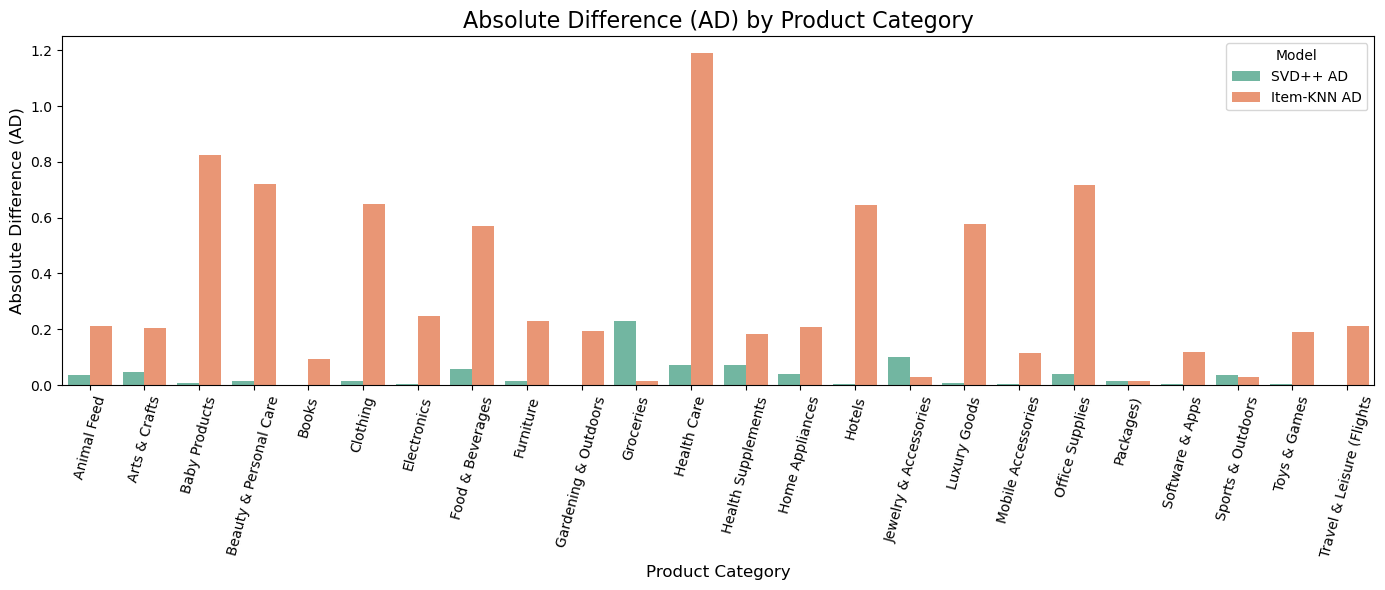

In [292]:
# Step 1: Create a DataFrame from AD values
ad_df = pd.DataFrame({
    "Product Category": list(svd_ad.keys()),
    "SVD++ AD": [val if val is not None else 0 for val in svd_ad.values()],
    "Item-KNN AD": [val if val is not None else 0 for val in knn_ad.values()]
})

# Step 2: Melt the DataFrame to long format for seaborn
ad_melted = ad_df.melt(id_vars="Product Category", 
                       value_vars=["SVD++ AD", "Item-KNN AD"], 
                       var_name="Model", 
                       value_name="Absolute Difference")

# Step 3: Plot the AD values per product category
plt.figure(figsize=(14, 6))
sns.barplot(data=ad_melted, x="Product Category", y="Absolute Difference", hue="Model", palette='Set2')

# Plot enhancements
plt.title("Absolute Difference (AD) by Product Category", fontsize=16)
plt.xlabel("Product Category", fontsize=12)
plt.ylabel("Absolute Difference (AD)", fontsize=12)
plt.xticks(rotation=75)
plt.legend(title="Model")
plt.tight_layout()
plt.show()


This plot compares the Absolute Difference (AD) in predicted satisfaction ratings between male and female customers for each product category. It measures the rating gap between gender groups, where a lower AD refers to a fairer treatment between male and female users. From the plot we can see that SVD++ consistently shows lower AD, meaning it gives more equitable recommendations across genders. Item-KNN exhibits high AD in several categories, which indicate potential gender bias in the Item-KNN model. 

---
**4) Fraction of Satisfied Users (FSU) for Group Fairness:**
---
Measruing the percentage of users receiving fair treatment.

In [293]:
def compute_customer_utility(predictions, product_categories):
    """
    Computes the average predicted rating (utility) for each customer 
    based on their top-5 recommendations.

    Parameters:
        predictions (dict):
            Dictionary mapping customer IDs to a list of (category, predicted_rating) tuples.
        product_categories (list[str]):
            List of valid product categories to include.

    Returns:
        dict: Mapping of customer ID to average utility (float).
              Customers with no valid predictions are assigned np.nan.
    """
    utilities = {}

    for customer_id, recs in predictions.items():
        ratings = [rating for category, rating in recs if category in product_categories]
        utilities[customer_id] = np.mean(ratings) if ratings else np.nan

    return utilities

In [294]:
def compute_fraction_satisfied_by_group(utilities, customer_demographics, group_key):
    """
    Calculates the fraction of satisfied users within each demographic group.
    A user is considered satisfied if their utility is >= their group's average utility.

    Parameters:
        utilities (dict):
            Mapping from customer ID to their average predicted utility.
        customer_demographics (dict):
            Mapping from customer ID to demographic attributes.
        group_key (str):
            The demographic column to group by (e.g., 'gender').

    Returns:
        DataFrame: Group-level statistics including:
            - Number of customers
            - Group average utility
            - Number of satisfied users
            - Fraction satisfied
    """
    records = [
        {
            "CustomerID": customer,
            "Utility": util,
            "Group": customer_demographics.get(customer, {}).get(group_key, "Unknown")
        }
        for customer, util in utilities.items()
        if not np.isnan(util)
    ]

    df = pd.DataFrame(records)

    # Calculate group average utility
    group_avg = df.groupby("Group")["Utility"].mean().reset_index().rename(columns={"Utility": "Group_Avg"})
    df = df.merge(group_avg, on="Group", how="left")

    # Determine satisfaction
    df["Satisfied"] = df["Utility"] >= df["Group_Avg"]

    # Aggregate results per group
    summary = df.groupby("Group").agg(
        Num_Customers=("CustomerID", "count"),
        Group_Avg=("Group_Avg", "first"),
        Num_Satisfied=("Satisfied", "sum")
    ).reset_index()

    summary["Fraction_Satisfied"] = summary["Num_Satisfied"] / summary["Num_Customers"]

    return summary

In [295]:
# Fraction of Satisfied Users Evaluation
# ---------------------------------------------------

product_categories = list(user_item_matrix.index)

# Compute utilities
svd_utilities = compute_customer_utility(svd_top_5_recs, product_categories)
knn_utilities = compute_customer_utility(knn_top_5_recs, product_categories)

# Demographic columns to evaluate
demographic_columns = ["gender", "age_group", "income_level", "education_level", "occupation", "marital_status"]

# SVD++ Model
print("=== SVD++ Group Fairness Evaluation (Fraction of Satisfied Users) ===")
for demo_col in demographic_columns:
    svd_summary = compute_fraction_satisfied_by_group(svd_utilities, customer_demographics, group_key=demo_col)
    print(f"\n[Demographic Column: {demo_col}]")
    print(svd_summary.to_string(index=False))

# Item-KNN Model
print("\n=== Item-KNN Group Fairness Evaluation (Fraction of Satisfied Users) ===")
for demo_col in demographic_columns:
    knn_summary = compute_fraction_satisfied_by_group(knn_utilities, customer_demographics, group_key=demo_col)
    print(f"\n[Demographic Column: {demo_col}]")
    print(knn_summary.to_string(index=False))

=== SVD++ Group Fairness Evaluation (Fraction of Satisfied Users) ===

[Demographic Column: gender]
      Group  Num_Customers  Group_Avg  Num_Satisfied  Fraction_Satisfied
    Agender             19   4.048887              8            0.421053
   Bigender             20   4.015978             10            0.500000
     Female            452   4.027661            191            0.422566
Genderfluid             17   4.030948              7            0.411765
Genderqueer             12   4.058424              4            0.333333
       Male            449   4.027218            202            0.449889
 Non-binary             16   4.045831              6            0.375000
 Polygender             15   4.047063              8            0.533333

[Demographic Column: age_group]
Group  Num_Customers  Group_Avg  Num_Satisfied  Fraction_Satisfied
18–25            222   4.028466             97            0.436937
26–30            165   4.018730             62            0.375758
31–35    

In [296]:
# --- Combine SVD++ and KNN summaries into one DataFrame ---
def build_combined_satisfaction_df(svd_utilities, knn_utilities, customer_demographics, group_key):
    svd_summary = compute_fraction_satisfied_by_group(svd_utilities, customer_demographics, group_key)
    svd_summary['Model'] = 'SVD++'

    knn_summary = compute_fraction_satisfied_by_group(knn_utilities, customer_demographics, group_key)
    knn_summary['Model'] = 'Item-KNN'

    combined_df = pd.concat([svd_summary, knn_summary])
    combined_df['Demographic'] = group_key
    return combined_df

demographic_columns = ["gender", "age_group", "income_level", "education_level", "occupation", "marital_status"]
satisfaction_all = pd.DataFrame()

for col in demographic_columns:
    df = build_combined_satisfaction_df(svd_utilities, knn_utilities, customer_demographics, group_key=col)
    satisfaction_all = pd.concat([satisfaction_all, df])

svd_summary_avg = satisfaction_all[satisfaction_all['Model'] == 'SVD++']['Fraction_Satisfied'].mean()
knn_summary_avg = satisfaction_all[satisfaction_all['Model'] == 'Item-KNN']['Fraction_Satisfied'].mean()

print("\n=== Overall Average Fraction Satisfied ===")
print(f"SVD++:    {svd_summary_avg:.4f}")
print(f"Item-KNN: {knn_summary_avg:.4f}")



=== Overall Average Fraction Satisfied ===
SVD++:    0.4368
Item-KNN: 0.5068


It shows the average proportion of users (across all demographic groups) whose predicted utility (average rating of top-5 recommendations) is greater than or equal to their group's average utility. It seems that item-KNN is doing a better job at evenly distributing satisfaction across users, while SVD++ is favoring fewer users more strongly — potentially leading to fairness concerns.

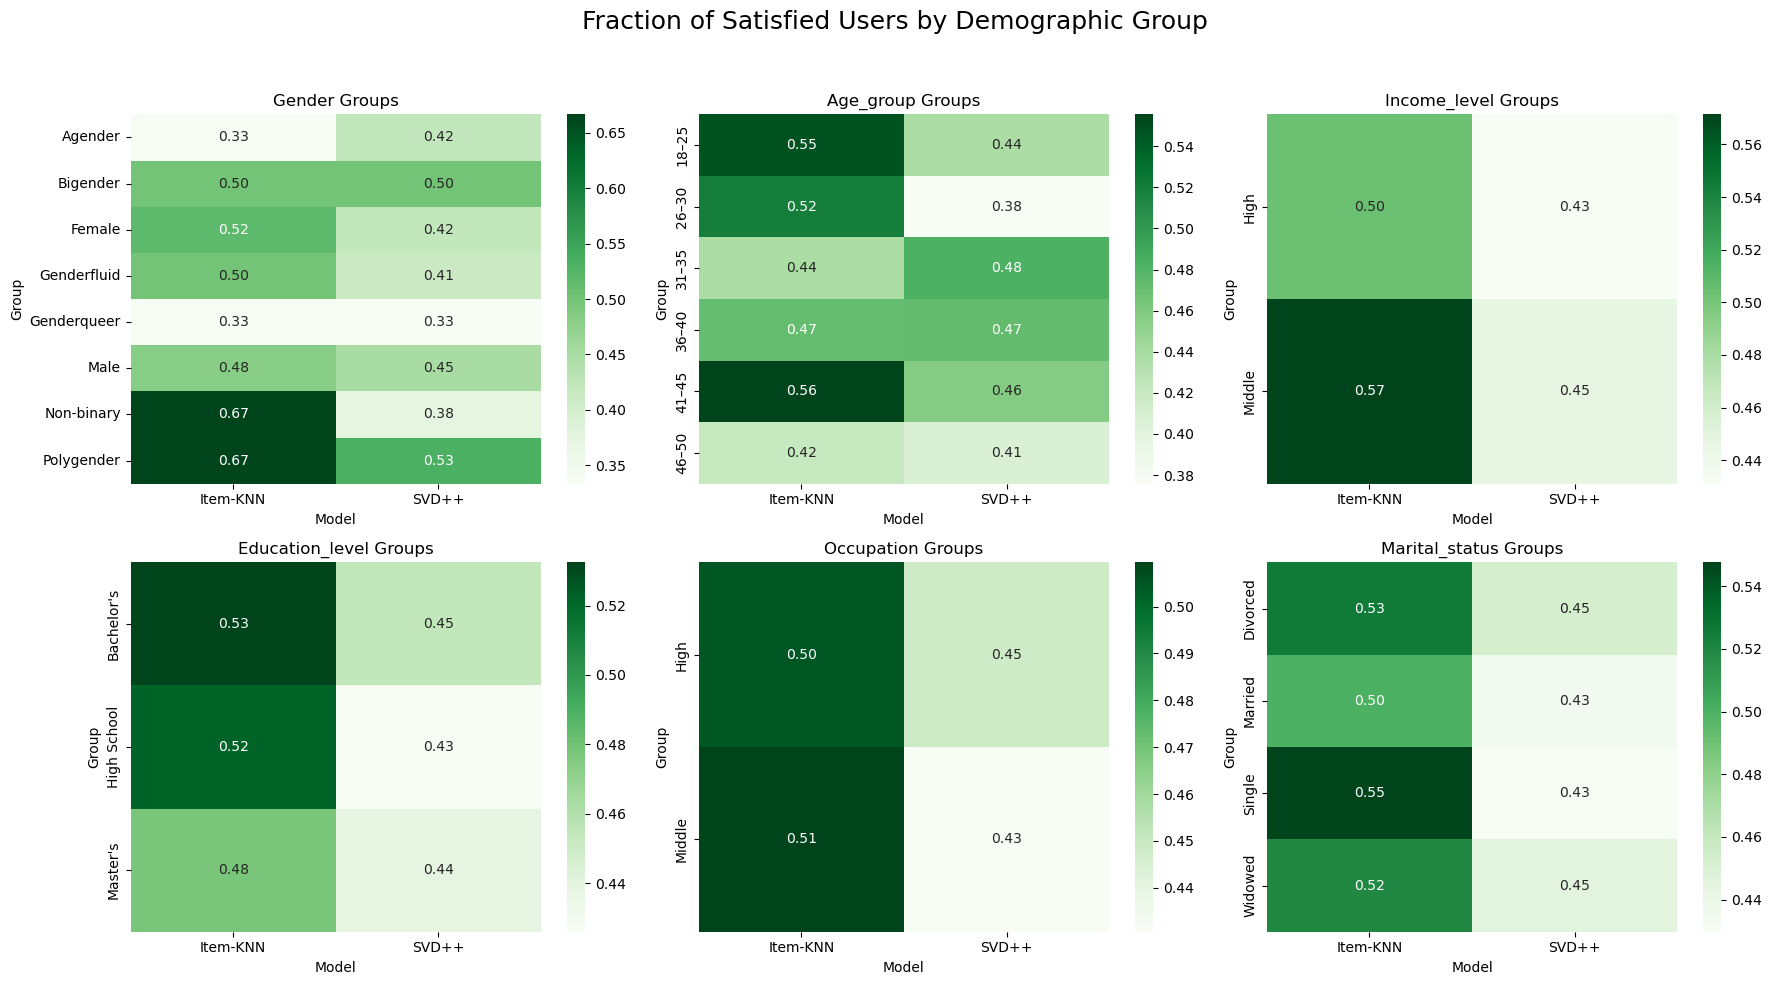

In [297]:
# Number of plots
n_plots = len(demographic_columns)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols  # Ceiling division

# Create the subplot grid
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 5 * n_rows))
axes = axes.flatten()  # Flatten to easily iterate

# Generate each heatmap
for i, col in enumerate(demographic_columns):
    df = build_combined_satisfaction_df(svd_utilities, knn_utilities, customer_demographics, group_key=col)
    pivot_df = df.pivot(index='Group', columns='Model', values='Fraction_Satisfied')
    
    sns.heatmap(
        pivot_df, 
        annot=True, 
        fmt=".2f", 
        cmap="Greens", 
        ax=axes[i],
    )
    
    axes[i].set_title(f"{col.capitalize()} Groups", fontsize=12)
    axes[i].set_xlabel("Model")
    axes[i].set_ylabel("Group")

# Hide any extra unused subplots (in case total plots < rows * cols)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Super title and layout
plt.suptitle("Fraction of Satisfied Users by Demographic Group", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Each heatmap shows the fraction of users in a demographic group (e.g., gender, age group, income level, etc.) whose predicted utility (average of top-5 recommendations) is greater than or equal to the group average. A higher value (closer to 1.0) means that more users in that group received recommendations above or equal to the group norm. From the plot we can see that Item-KNN has consistently higher satisfaction fractions across most demographic groups. SVD++ has noticeably lower satisfaction rates. This suggests Item-KNN may provide a more inclusive or balanced experience in terms of satisfaction.

High satisfaction isn’t always “good” in fairness terms if other groups are left behind. Fairness involves both equal access and balanced benefit — so while KNN shows higher satisfaction, variance and envy metrics still matter.

---

Conclusion:
---
Across all fairness dimensions, the SVD++ model consistently outperforms the Item-KNN model, especially in terms of individual fairness (lower variance and mean average envy per user) and group fairness (more consistent treatment within demographic groups). SVD++ shows more stable and equitable recommendations regardless of users’ gender, age, income, or other attributes, ensuring similar quality across peers.

In contrast, Item-KNN, while achieving higher raw satisfaction scores, displays significant disparities within and across groups—indicating potential issues like intra-group favoritism or bias. This model tends to treat users more unequally, especially visible in higher group-level envy and variance scores, and large gaps in gender-based treatment.